## Replicate Quiet-STAR's main results, and make it model agnostic

Eval on the same datasets during training?

Also add MMLU?

CoT for gsm8k?

What does eval need for COT eval? -- going through cot eval script now from them... They use the forward pass just the same very odd!!!! very inefficient!!!!! but whatever I guess it is easier to code.


Making this system work for any model, how will I deal with the idea of a mixing head? combining the logits in a single stream and predicting with them?

Also want to be able to handle the idea of multiple models used in an ensemble to get data uncertainty estimates. (https://pytorch.org/tutorials/intermediate/ensembling.html.)


In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

from pprint import pprint
from copy import deepcopy
from collections import defaultdict

In [2]:
print("batched gen required memory for first inference pass", 256 * 8 * 256) # memory consumption is reduced massively by the parallel attention head implementation.
print("additionally the past_key_value will have a batch of", 256 * 8, "the entire time but the num keys/values will be 1")
print("parallel atten impl required mem for first inference pass", 256 * 8, "here the past_key_value batch size will be", 8, "and 256 will be in the number of key and values dimension")

print("ultimately we don't take advantage of the repeated sequences if we are forced to generate a thought for every token, but we could argue that we can get diversity in place of this. we may want to instead do better with more context than with less context???")

batched gen required memory for first inference pass 524288
additionally the past_key_value will have a batch of 2048 the entire time but the num keys/values will be 1
parallel atten impl required mem for first inference pass 2048 here the past_key_value batch size will be 8 and 256 will be in the number of key and values dimension
ultimately we don't take advantage of the repeated sequences if we are forced to generate a thought for every token, but we could argue that we can get diversity in place of this. we may want to instead do better with more context than with less context???


In [3]:
### Hyper params
# policy_model_name = "meta-llama/Llama-3.2-1B" 
# Q_model_name = "meta-llama/Llama-3.2-1B" 
# reward_y_z_x_model_name = "meta-llama/Llama-3.2-1B" 

# policy_model_name = "openai-community/gpt2" 
# Q_model_name = "openai-community/gpt2" 
# reward_y_z_x_model_name = "openai-community/gpt2" 

# "mistralai/Mistral-7B-v0.1" ? 
quiet_star_model_name = "openai-community/gpt2" # "meta-llama/Llama-3.2-1B" # 

tokenizer_sot_token = "<|sot_token|>"
tokenizer_eot_token = "<|eot_token|>"
start_of_thought_token_init_embedding = "---" # None ??
end_of_thought_token_init_embedding = "---" # None ??

embedding_scaling = 1 # 1e2 TODO: get this working in the forward pass
reinforce_loss_scaling = 1e6
n_sampled_thoughts = 2 # for trice average
original_loss_weight = 0.5
base_loss_scaling = 1
n_talk_tokens = 4
n_thought_tokens = 2 # normally 12 '

device = 'cuda'

# mean resizing for new tokens will happen if the init embedding is set to None above.
### end

In [4]:
tokenizer = AutoTokenizer.from_pretrained(quiet_star_model_name)
base_model = AutoModelForCausalLM.from_pretrained(quiet_star_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
assert tokenizer.pad_token_id is not None

In [5]:
def add_special_tokens_to_model_and_tokenizer(specific_model, specific_tokenizer, embedding_scaling):
    if tokenizer_sot_token not in specific_tokenizer.get_added_vocab():
        # new_tokens = [tokenizer_sot_token, tokenizer_eot_token]
        specific_tokenizer.add_tokens(tokenizer_sot_token, special_tokens=True)
        specific_model.resize_token_embeddings(len(specific_tokenizer), mean_resizing=True)
        tokenizer_sot_token_id = specific_tokenizer.get_added_vocab()[tokenizer_sot_token]

        specific_tokenizer.add_tokens(tokenizer_eot_token, special_tokens=True)
        specific_model.resize_token_embeddings(len(specific_tokenizer), mean_resizing=True)
        tokenizer_eot_token_id = specific_tokenizer.get_added_vocab()[tokenizer_eot_token]
        with torch.no_grad():
            model_embeddings = specific_model.get_input_embeddings().weight.data
            if start_of_thought_token_init_embedding is not None:
                sot_embedding = model_embeddings[tokenizer.encode(start_of_thought_token_init_embedding, add_special_tokens=False)[0]]
                model_embeddings[tokenizer_sot_token_id] = sot_embedding / embedding_scaling
            if end_of_thought_token_init_embedding is not None:
                eot_embedding = model_embeddings[tokenizer.encode(end_of_thought_token_init_embedding, add_special_tokens=False)[0]]
                model_embeddings[tokenizer_eot_token_id] = eot_embedding / embedding_scaling
add_special_tokens_to_model_and_tokenizer(base_model, tokenizer, embedding_scaling)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# TODO: to test if this is truly working I would want to support at least the eval datasets that quiet-star works with, as well as the model which quiet-star works with.
# For this I would need to support much longer sequences like 128 or 256 ideally. 
# so change the way my forward pass is done. calculate all the input sequences which will be used in the generation batch, then essentially run those through the model doing gradient accumulation on the loss? 
# (would require a backward pass). I could change the way the data is preprocessed to take this into account. Then the eval would have to be calculated only when a whole example has been able to pass through.
# This would likely require my own training loop and then eventually figuring out how to do distributed training with Mistral, so I should come back to this idea if I have time.
# Right now, I can add some parts of the DPO training loop which I need into their codebase.

In [6]:
def expand_to_triangular_sequence_for_parallel_generation(elements_per_batch_element, inputs, fill_value, n_talk_tokens, predict_all=False):
    if predict_all:
        n_talk_tokens = 0
    # predict_all will create thoughts which do not have enough tokens to calculate loss, this is useful for COT setting
    max_seq = inputs.size(1)
    max_thoughts_producable_with_enough_talk_tokens_remaining = (elements_per_batch_element - (n_talk_tokens)).clamp(min=0).sum().item() # minus 1 because we only predict n_talk_tokens, and without this, we would predict n_talk_tokens + 1 because one for every token and then one for eot token.
    expanded_inputs = torch.full(size=(max_thoughts_producable_with_enough_talk_tokens_remaining, max_seq - (n_talk_tokens)),
                                 fill_value=fill_value,
                                 dtype=inputs.dtype,
                                 device=inputs.device)
    batch_being_filled = 0
    for b_i in range(inputs.size(0)):
        # each batch element should be expanded to fit the
        elements_in_b_i = elements_per_batch_element[b_i].item()
        if n_talk_tokens >= elements_in_b_i and not predict_all:
            continue
        num_sequences_with_enough_talk_tokens_remaining = elements_in_b_i - (n_talk_tokens)
        sequence_b_i_start_index = max_seq - elements_in_b_i
        triangular_inputs = inputs[[b_i], ...].expand(elements_in_b_i,-1).gather(1, (sequence_b_i_start_index + torch.arange(num_sequences_with_enough_talk_tokens_remaining, device=inputs.device, dtype=torch.long)[None, :] - torch.arange(num_sequences_with_enough_talk_tokens_remaining, device=inputs.device, dtype=torch.long)[:, None]).triu())
        ones_like_triangular_inputs = torch.ones_like(triangular_inputs)
        triangular_inputs = triangular_inputs.triu() + (ones_like_triangular_inputs - ones_like_triangular_inputs.triu()) * fill_value            
        expanded_inputs[batch_being_filled: batch_being_filled + num_sequences_with_enough_talk_tokens_remaining, -num_sequences_with_enough_talk_tokens_remaining:] = triangular_inputs
        batch_being_filled += num_sequences_with_enough_talk_tokens_remaining
    return expanded_inputs

def get_next_tokens_for_thoughts(elements_per_batch_element, input_ids, n_talk_tokens_to_leave_room_for, fill_value=-100, predict_all=False, get_token_before_label=False): 
    # get_token_before_label is useful if you want to pluck the hidden state used to predict the next token for the base model predictions.
    n_labels_next_tokens = n_talk_tokens_to_leave_room_for
    if predict_all:
        n_talk_tokens_to_leave_room_for = 0
        
    # predict_all will populate next_tokens_for_thoughts which do not have enough tokens to calculate loss, this is useful for COT setting
    # we assume every thought needs at least n_talk_tokens after it. 
    max_seq = input_ids.size(1)
    max_thoughts_producable_with_enough_talk_tokens_remaining = (elements_per_batch_element - n_talk_tokens_to_leave_room_for).clamp(min=0).sum().item()
    remaining_input_shape = tuple(input_ids.shape[2:]) # to support using this same function for base_hidden_state extraction
    next_tokens_for_thoughts = torch.full((max_thoughts_producable_with_enough_talk_tokens_remaining, n_labels_next_tokens) + remaining_input_shape, fill_value=fill_value, dtype=input_ids.dtype, device=input_ids.device)
    batch_being_filled = 0
    input_ids = torch.concat([input_ids, torch.full_like(input_ids[:,[0]], fill_value=fill_value)], dim=1)# This to support -100 in the labels.

    for b_i, elements_in_b_i in enumerate(elements_per_batch_element):
        elements_in_b_i = elements_in_b_i.item()
        if n_talk_tokens_to_leave_room_for >= elements_in_b_i:
            continue
        num_sequences_with_enough_talk_tokens_remaining = elements_in_b_i - n_talk_tokens_to_leave_room_for
        sequence_b_i_start_index = max_seq - elements_in_b_i
        indices_of_next_tokens = sequence_b_i_start_index + torch.concat(list(torch.arange(num_sequences_with_enough_talk_tokens_remaining, 0, -1, device=input_ids.device, dtype=torch.long)[:, None] + i for i in range(n_labels_next_tokens)), dim=-1)
        if get_token_before_label:
            indices_of_next_tokens -= 1
        for additional_shape in remaining_input_shape:
            indices_of_next_tokens = indices_of_next_tokens[...,None].expand(*(tuple(indices_of_next_tokens.shape) + (additional_shape,)))
        # mechanism to support -100 placement at last index will be to append to the input_ids a last sequence element which is just -100s, then make indices which go past the end only grab the end element.
        indices_of_next_tokens = indices_of_next_tokens.clamp(max=max_seq)
        talk_tokens_for_b_i_thoughts = input_ids[[b_i], ...].expand(*((num_sequences_with_enough_talk_tokens_remaining, -1) + remaining_input_shape)).gather(1, indices_of_next_tokens)
        next_tokens_for_thoughts[batch_being_filled: batch_being_filled + num_sequences_with_enough_talk_tokens_remaining] = talk_tokens_for_b_i_thoughts
        batch_being_filled += num_sequences_with_enough_talk_tokens_remaining
    return next_tokens_for_thoughts

def get_input_sized_logits(inputs, logits, elements_per_batch_element):
    # this n_sampled_thoughts = 1, and n_talk = 1, and that a thought was generated after every token, and used to predict only the next token.
    return_logits = torch.zeros(tuple(inputs.shape) + tuple(logits.shape[-1:]), device=logits.device, dtype=logits.dtype)
    # then we have to go through for every input
    batch_being_filled = 0
    for b_i, elements_in_b_i in enumerate(elements_per_batch_element):
        return_logits[b_i, -elements_in_b_i:] = logits[batch_being_filled:batch_being_filled+elements_in_b_i:, -1].flip(dims=(0,))
        batch_being_filled += elements_in_b_i
    return return_logits
# get_input_sized_logits(base_input_ids, talk_logits, elements_per_batch_element)
class QuietSTARPolicyModel(nn.Module):
    def __init__(self, base_llm_model, n_sampled_thoughts, n_thought_tokens, n_talk_tokens, embedding_scaling, reinforce_loss_scaling, original_loss_weight, base_loss_scaling):
        super().__init__()
        self.base_llm_model = base_llm_model
        self.n_sampled_thoughts = n_sampled_thoughts
        self.n_thought_tokens = n_thought_tokens
        self.n_talk_tokens = n_talk_tokens
        self.embedding_scaling = embedding_scaling
        self.reinforce_loss_scaling = reinforce_loss_scaling
        self.original_loss_weight = original_loss_weight
        self.base_loss_scaling = base_loss_scaling
        assert tokenizer.pad_token_id is not None, "pad token id cannot be None"
        self.pad_token_id = tokenizer.pad_token_id
        self.lm_head = base_llm_model.lm_head
        self.mixing_head = nn.Sequential(
            nn.Linear(self.base_llm_model.config.hidden_size * 2, self.base_llm_model.config.hidden_size),
            nn.ReLU(),
            nn.Linear(self.base_llm_model.config.hidden_size, self.base_llm_model.config.hidden_size),
            nn.ReLU(),
            nn.Linear(self.base_llm_model.config.hidden_size, 1, bias=False)
        )
        with torch.no_grad():
            # zero the last linear layer of the mixing head to start, so we rely only on the base model before trying to use our generated thoughts at all.
            list(self.mixing_head.modules())[-1].weight.zero_()
        # decorate the forward function
        if not hasattr(self.base_llm_model, "old_forward"):
            self.base_llm_model.old_forward = self.base_llm_model.forward
        self.base_llm_model.forward = self.forward
    def forward(self, *args, **kwargs): # for the purposes of testing with quiet-star's evals, all I have to do is parallely predict next token likelihoods over all tokens in some sequence.
        # for passing through this forward pass to predict the next token on a given vocab, we would want to generate
        # potentially only at the ends of the input ids? or for every token like a standard forward pass would do?
        # if someone passes in a key_value_cache, we would want to behave appropriately by having it only generate a thought for the tokens in the key value cache
        # to begin with we don't really have to replicate this desired effect, just generate a thought for every token, and see if we can get this to work. Even quietSTAR doesn't have a method to only think for the last token!
        # in a single forward pass, we take in the input ids, 
        # print("kwargs", kwargs.keys())

        # if "input_ids" in kwargs:
        #     print(kwargs['input_ids'].shape)
        # if "use_cache" in kwargs:
        #     print(kwargs["use_cache"])
        # if "past_key_values" in kwargs:
        #     print(kwargs["past_key_values"][0][0].shape)
        if "position_ids" in kwargs:
            raise Exception(f"unexpected position_ids in kwargs {kwargs['position_ids'].shape=} with {kwargs.keys()=}")
        base_input_ids = kwargs.pop('input_ids')
        base_attention_mask = kwargs.pop('attention_mask')
        base_input_position_ids = (base_attention_mask.cumsum(-1) - 1).clamp(min=0)
        base_outputs = self.base_llm_model.old_forward(input_ids=base_input_ids,
                                                       attention_mask=base_attention_mask,
                                                       position_ids=base_input_position_ids,
                                                       return_dict=True,
                                                       output_hidden_states=True,
                                                       *args, **kwargs)
        base_hidden_states = base_outputs['hidden_states'][-1] # len(base_outputs['hidden_states']) = input + one for every layer in that order. so base_outputs['hidden_states'][-1] gets last layer
        
        thoughts_for_every_token_sub_sequence_outputs, next_tokens_for_thoughts, context_sot_attention_mask, elements_per_batch_element = self.generate_for_every_token(base_input_ids, base_attention_mask)

        context_sot_thought = thoughts_for_every_token_sub_sequence_outputs.sequences
        thought_input_ids = context_sot_thought[:, -self.n_thought_tokens:] # this if we do some past_key_value based impelmentation. (for speed)
        eot_tokens_to_right_pad = torch.full_like(context_sot_thought[:, [0]], fill_value=tokenizer.get_added_vocab()[tokenizer_eot_token])
        context_sot_thought_eot = torch.concat([context_sot_thought, eot_tokens_to_right_pad], dim=-1)
        # past_key_values = thoughts_for_every_token_sub_sequence_outputs.past_key_values # this will be useful later to speed up parallel generation implementation.
        # now to get the probability of the next self.n_talk_tokens by feeding in the 

        # context_sot_thought_eot_label_padding = torch.full_like(context_sot_thought_eot, fill_value=-100, dtype=torch.long)
        # talk_token_labels = torch.concat([context_sot_thought_eot_label_padding, next_tokens_for_thoughts], dim=-1)

        next_tokens_for_thoughts_input_ids = next_tokens_for_thoughts.clone()
        next_tokens_for_thoughts_input_ids[next_tokens_for_thoughts_input_ids == -100] = self.pad_token_id
        context_sot_thought_eot_talk_input_ids = torch.concat([context_sot_thought_eot, next_tokens_for_thoughts_input_ids], dim=-1)
        next_tokens_for_thoughts_attention_mask = next_tokens_for_thoughts.clone()
        next_tokens_for_thoughts_attention_mask[next_tokens_for_thoughts_attention_mask != -100] = 1
        next_tokens_for_thoughts_attention_mask[next_tokens_for_thoughts_attention_mask == -100] = 0
        context_sot_thought_eot_talk_attention_mask = torch.concat([context_sot_attention_mask, torch.ones_like(thought_input_ids), torch.ones_like(eot_tokens_to_right_pad), next_tokens_for_thoughts_attention_mask], dim=-1)
        
        context_sot_thought_eot_talk_position_ids = (context_sot_thought_eot_talk_attention_mask.cumsum(-1) - 1).clamp(min=0)
        thought_outputs = self.base_llm_model.old_forward(input_ids=context_sot_thought_eot_talk_input_ids[:, :-1], 
                                                          attention_mask=context_sot_thought_eot_talk_attention_mask[:, :-1],
                                                          position_ids=context_sot_thought_eot_talk_position_ids[:,:-1],
                                                        #   labels=talk_token_labels, # technically we don't need the last talk token except to see what the model thinks about the very last token which is only useful for generation. # this was commented out because we manually compute the loss and ignore the extra single next token thing.
                                                          output_hidden_states=True,
                                                          return_dict=True)
        thought_hidden_states = thought_outputs["hidden_states"][-1][:, -self.n_talk_tokens:] # how to ensure that we only have the hidden states for tokens pretaining to the talk tokens. just use the label tokens as a guide?
        # expand the base_hidden_states for linearly combining them! this is batch_size x max_seq x 768, but needs to be num_thoughts x max_seq x 768, and it is difficult to know how many times to repeat each row,
        expanded_base_hidden_states = get_next_tokens_for_thoughts(elements_per_batch_element, base_hidden_states, self.n_talk_tokens, predict_all=True, get_token_before_label=True) # [list(j for j, g in enumerate(thoughts_per_batch_element) for i in range(g))]
        expanded_base_hidden_states = expanded_base_hidden_states.repeat_interleave(self.n_sampled_thoughts, dim=0)
        mixing_factor = self.mixing_head(torch.concat([expanded_base_hidden_states, thought_hidden_states], dim=-1))
        mixed_hidden_states = expanded_base_hidden_states * (1 - mixing_factor) + thought_hidden_states * mixing_factor
        talk_logits = self.lm_head(mixed_hidden_states)
        
        return_dict: dict = defaultdict(lambda : None)
        return_dict["last_hidden_states"] = mixed_hidden_states # , "logits": talk_logits} logits will very strange shape, and are only used externally for cot eval. More can be done to combine the different predictions later, but for now, Just prepare logits if n_talk_tokens is 1, and get logits from every prediction, and line them in a row.

        # TODO: fix the off by one error where I do not generate a token for the end of the sequence, because I don't generate a thought for the very last token because I assumed that we would always want the full context of self.n_talk_tokens.
        #       or just leave it, and return the logits from this method only when the n_talk is 1, because that is the only time it makes sense, because we have one prediction for every seq token 
        # during the COT eval, how do they generate the next token?
        if "labels" in kwargs: # without the labels defined, we still want to get the logits for every token position. when n_talk_tokens is greater than 1, we can just average them? or just return the logit corresponding to when this is the first thought. What quietstar does is they just output the logits which would predict the next token after n_thought. so at that point it is only logits for the seq_len - n_talk + 1
            # move labels to correct device to enable model parallelism
            next_tokens_for_thoughts = next_tokens_for_thoughts.to(talk_logits.device)
            # Shift so that tokens < n predict n
            talk_shift_logits = talk_logits.contiguous()
            talk_shift_labels = next_tokens_for_thoughts.contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss(reduction='none') # this does mean reduction, but we need to comute the non reduced version to be able to calculate reward as defined by change in log likelihood (new_ll - old_ll)
            talk_loss_per_talk_token = loss_fct(talk_shift_logits.view(-1, talk_shift_logits.size(-1)), talk_shift_labels.view(-1)).view(*talk_shift_labels.shape)
            return_dict["talk_loss"] = talk_loss_per_talk_token.sum() / (talk_shift_labels != -100).sum()

            base_labels = kwargs["labels"]
            base_shift_logits = base_outputs['logits'][:,:-1].contiguous()
            base_shift_labels = base_labels[:,1:].contiguous()
            base_talk_loss = loss_fct(base_shift_logits.view(-1, base_shift_logits.size(-1)), base_shift_labels.view(-1)).view(*base_shift_labels.shape)
            expanded_base_talk_loss = get_next_tokens_for_thoughts(elements_per_batch_element, base_talk_loss, self.n_talk_tokens, fill_value=0, predict_all=True, get_token_before_label=False)
            expanded_base_talk_loss = expanded_base_talk_loss.repeat_interleave(self.n_sampled_thoughts, dim=0)
            return_dict["base_talk_loss"] = base_talk_loss.sum() / (base_shift_labels != -100).sum()
            change_in_log_likelihood = expanded_base_talk_loss - talk_loss_per_talk_token
            # reward per thought is stored in the rows
            # num_predicted_labels_per_thought = (talk_shift_labels != -100).sum(-1)
            reward_per_thought = change_in_log_likelihood.sum(-1) 
            # / num_predicted_labels_per_thought # I think I should just do the sum over the nll reduction because average would remove information about number of tokens predicted.
            # reward_per_thought[num_predicted_labels_per_thought == 0] = 0.0 # remove the nan division by zeros
            
            # goal is to perform trice, which should be average performance on the prefix
            control_variate = reward_per_thought.view(-1, self.n_sampled_thoughts).mean(-1).repeat_interleave(self.n_sampled_thoughts, dim=0) # if there are some
            control_adjusted_reward_per_thought = reward_per_thought - control_variate
            positive_control_adjusted_reward_per_thought = control_adjusted_reward_per_thought.clamp(min=0).detach()
            # now we need log_thought_probabilities, to be able to get the reinforce loss
            start_of_thought_index_in_context_sot_thought_eot_labels_m1 = -self.n_thought_tokens-self.n_talk_tokens-1
            end_of_thought_index_in_context_sot_thought_eot_labels_m1 = -self.n_talk_tokens-1
            thought_log_probabilities = thought_outputs["logits"][:, start_of_thought_index_in_context_sot_thought_eot_labels_m1 : end_of_thought_index_in_context_sot_thought_eot_labels_m1].log_softmax(-1).gather(-1, thought_input_ids[..., None]).squeeze(-1).sum(-1)
            policy_loss = - positive_control_adjusted_reward_per_thought * thought_log_probabilities
            policy_loss = policy_loss.mean()
            # base_outputs['loss'] # this should be defined if there are labels.
            return_dict['base_and_talk_loss'] = (return_dict["base_talk_loss"] * self.original_loss_weight + return_dict["talk_loss"]  * (1 - self.original_loss_weight))
            return_dict['policy_loss'] = policy_loss
            return_dict['loss'] = return_dict['policy_loss'] * self.reinforce_loss_scaling + return_dict['base_and_talk_loss'] * self.base_loss_scaling
            
        else:
            # no loss computation when labels aren't given, just give the language models predictions for the next token, which we will define to be the one right after the last talk token. 
            # This is nice for our generation evals, but doesn't reflect our loss well if we report it in the evals :<
            assert self.n_talk_tokens == 1, "num_talk_tokens must be one to return logits, and that is the only thing that makes sense if we are doing a forward pass without labels."
            raise NotImplemented

        if self.n_talk_tokens == 1 and self.n_sampled_thoughts == 1: # we want one logit per token, so we have to gather the corresponding token locations.
            # logits on the corresponding token locations.
            return_dict['logits'] = get_input_sized_logits(base_input_ids, talk_logits, elements_per_batch_element)
        # we now have the hidden states num_thoughts x max_seq x 768 now using the same code we used to get the label mask, we can get the base hidden states corresponding to each label position.
        return tuple(return_dict[key] for key in ['loss', "talk_loss", "base_talk_loss", "base_and_talk_loss", "policy_loss", 'last_hidden_states', 'logits']) # must return a tuple when working with huggingface trainer.
    def base_model_generate(self, *args, **kwargs):
        return self.generate(self.base_llm_model.old_forward, *args, **kwargs)
    def generate(self, forward_function, *args, **kwargs):
        temp_forward = forward_function
        try:
            self.base_llm_model.forward = self.base_llm_model.old_forward
            gen_output = self.base_llm_model.generate(*args, **kwargs)
        except:
            raise
        finally:
            self.base_llm_model.forward = temp_forward
        return gen_output
        # now the choice is do I generate a thought per token, or do I just generate a single next token. The standard interface would be to support sampling the next token with this method, so I will create a different method to support the operation I want.

    def generate_for_every_token(self, input_ids, attention_mask):
        # this is simply just spreading out every token as a generation task.
        # in the future, I can speed this up with past_key_values from a single standard forward pass on the input_ids as one 
        elements_per_batch_element = attention_mask.sum(-1)
        # (num_tokens) x max_seq # the effective batch size is way larger. possibly max_seq * original_batch_size

        # the strategy is to make only as many thoughts to where you have at least n_talk remaining tokens for labels.
        thoughts_per_batch_element = (elements_per_batch_element - self.n_talk_tokens).clamp(min=0)
        next_tokens_for_thoughts = get_next_tokens_for_thoughts(elements_per_batch_element, input_ids, self.n_talk_tokens, predict_all=True) # input_ids
        expanded_input_ids = expand_to_triangular_sequence_for_parallel_generation(elements_per_batch_element, input_ids, fill_value=self.pad_token_id, n_talk_tokens=self.n_talk_tokens, predict_all=True)
        expanded_attention_mask = expand_to_triangular_sequence_for_parallel_generation(elements_per_batch_element, attention_mask, fill_value=0, n_talk_tokens=self.n_talk_tokens, predict_all=True)
        
        sot_tokens_to_right_pad = torch.full_like(expanded_input_ids[:, [0]], fill_value=tokenizer.get_added_vocab()[tokenizer_sot_token])
        expanded_input_ids = torch.concat([expanded_input_ids, sot_tokens_to_right_pad], dim=-1)
        expanded_input_ids = expanded_input_ids.repeat_interleave(self.n_sampled_thoughts, 0)
        mask_to_right_pad = torch.full_like(expanded_attention_mask[:, [0]], fill_value=1)
        expanded_attention_mask = torch.concat([expanded_attention_mask, mask_to_right_pad], dim=-1)
        expanded_attention_mask = expanded_attention_mask.repeat_interleave(self.n_sampled_thoughts, 0)

        next_tokens_for_thoughts = next_tokens_for_thoughts.repeat_interleave(self.n_sampled_thoughts, 0)
        # print(expanded_input_ids)
        # print(expanded_attention_mask)
        # import ipdb; ipdb.set_trace()
        outputs = self.base_model_generate(input_ids=expanded_input_ids, attention_mask=expanded_attention_mask, max_new_tokens=self.n_thought_tokens, do_sample=True, return_dict_in_generate=True)
        # print(outputs.keys())
        return outputs, next_tokens_for_thoughts,  expanded_attention_mask, elements_per_batch_element

quiet_star_model = QuietSTARPolicyModel(deepcopy(base_model), n_sampled_thoughts, n_thought_tokens, n_talk_tokens, embedding_scaling, reinforce_loss_scaling, original_loss_weight, base_loss_scaling).to(device)
# quiet_star_model = QuietSTARPolicyModel(deepcopy(base_model), 1, n_thought_tokens, 1, embedding_scaling, reinforce_loss_scaling, original_loss_weight, base_loss_scaling).to(device)
base_inputs = tokenizer(["Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", "how is it going Schrammy?"], return_tensors='pt', padding=True, padding_side="left", add_special_tokens=True).to(device)
# print(base_inputs)
base_input_labels = base_inputs.input_ids.clone()
base_input_labels[base_inputs.attention_mask == 0] = -100
base_input_labels[torch.arange(base_input_labels.size(0)), base_inputs.attention_mask.argmax(dim=-1)] = -100 # gets the first location? I don't know  if this is a safe bet, but whatever for now...
quiet_star_model.forward(**base_inputs, labels=base_input_labels)
# quiet_star_model.generate_for_every_token(**base_inputs)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


(tensor(4.0268, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3.9827, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.0708, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.0268, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0., device='cuda:0', grad_fn=<MeanBackward0>),
 tensor([[[ 1.1575e-01, -3.7863e-02,  5.6798e-01,  ...,  4.7920e-01,
           -2.8237e-01,  1.6246e-01],
          [-1.0000e+02, -1.0000e+02, -1.0000e+02,  ..., -1.0000e+02,
           -1.0000e+02, -1.0000e+02],
          [-1.0000e+02, -1.0000e+02, -1.0000e+02,  ..., -1.0000e+02,
           -1.0000e+02, -1.0000e+02],
          [-1.0000e+02, -1.0000e+02, -1.0000e+02,  ..., -1.0000e+02,
           -1.0000e+02, -1.0000e+02]],
 
         [[ 1.1575e-01, -3.7863e-02,  5.6798e-01,  ...,  4.7920e-01,
           -2.8237e-01,  1.6246e-01],
          [-1.0000e+02, -1.0000e+02, -1.0000e+02,  ..., -1.0000e+02,
           -1.0000e+02, -1.0000e+02],
          [-1.0000e+02, -1.0000e+02, -1.0000e+02,  ..., -1.0000e+02,

In [7]:
from transformers import TrainingArguments, Trainer
import datasets
from datasets import load_dataset
import random
random_seed = 42

dataset_name = 'open-web-math/open-web-math'
n_examples = 1_000
max_seq_len = 32


dataset = load_dataset(
    dataset_name,
    "en" if "c4" in dataset_name else "default",
    split=f"train[:{n_examples}]",
    # ignore_verifications=True,
    verification_mode=datasets.VerificationMode.NO_CHECKS,
    num_proc=4,
    # cache_dir=root_prefix + "cache/datasets/",
)
def get_preprocess_function(max_length):
    def preprocess_function(examples):
        if isinstance(examples["text"], str):
            dataset_transform = lambda xs: [xs["text"]]
        else:
            dataset_transform = lambda xs: xs["text"]
        all_tokenized = [tokenizer.encode(t, return_tensors="pt", ) for t in dataset_transform(examples)]
        new_tokenized = [{"input_ids": t} for t in all_tokenized]
        for i, t in enumerate(new_tokenized):
            new_tokenized[i]["input_ids"] = truncate_or_pad(t['input_ids'], tokenizer.pad_token_id, max_length)
        new_input_ids = torch.cat([t["input_ids"] for t in new_tokenized], dim=0)
        new_attention_mask = (new_input_ids != tokenizer.pad_token_id).long()
        tokenized = {"input_ids": new_input_ids, "attention_mask": new_attention_mask}
        tokenized["labels"] = tokenized["input_ids"].clone()
        tokenized["labels"][new_attention_mask == 0] = -100
        tokenized['labels'][torch.arange(new_attention_mask.size(0)), new_attention_mask.argmax(dim=-1)] = -100
        return tokenized
    # def preprocess_function(examples):
    #     if isinstance(examples["text"], str):
    #         dataset_transform = lambda xs: [xs["text"]]
    #     else:
    #         dataset_transform = lambda xs: xs["text"]
    #     print(examples)
    #     print()
    #     all_tokenized = tokenizer(dataset_transform(examples), return_tensors="pt", padding=True, padding_side='left', max_length=max_seq_len)
    #     # all_tokenized = [tokenizer(t, return_tensors="pt", padding_side='left', max_length=max_seq_len) for t in dataset_transform(examples)] # Jakob: changed to padding side right
    #     # new_tokenized = [{"input_ids": t.input_ids,} for t in all_tokenized]
    #     assert tokenizer.pad_token_id is not None, "Must have a valid pad token, but it was None."
    #     new_input_ids = all_tokenized.input_ids
    #     new_attention_mask = all_tokenized.attention_mask
    #     tokenized = {"input_ids": new_input_ids, "attention_mask": new_attention_mask}
    #     tokenized["labels"] = tokenized["input_ids"].clone()
    #     tokenized['labels'][new_attention_mask == 0] = -100 # Jakob: changed
    #     tokenized['labels'][torch.arange(new_attention_mask.size(0)), new_attention_mask.argmax(dim=-1)] = -100 # gets the first location? I don't know  if this is a safe bet, but whatever for now...
    #     # tokenized['position_ids'] = (base_inputs.attention_mask.cumsum(-1) - 1).clamp(min=0)
    #     # tokenized['labels'][new_attention_mask == 0] = -100 # Jakob: changed
    #     return tokenized
    return preprocess_function
def truncate_or_pad(t, padding_idx=0, max_length=256): # now left padding
    if t.shape[1] > max_length:
        start = random.randint(0, t.shape[1] - max_length)
        t = t[:, start:start + max_length]
    else:
        padding = torch.zeros(t.shape[0], max_length - t.shape[1], dtype=t.dtype, device=t.device)
        t = torch.cat([padding + padding_idx, t], dim=1) # left now.
    return t
train_dataset = dataset.shuffle(seed=random_seed).map(get_preprocess_function(max_seq_len), batched=True, writer_batch_size=200, remove_columns=["text"])
root_prefix = 'quiet_star_replicate_runs/'
full_batch_size = 2
n_passes_global = 2
gradient_accumulation_steps = 1
import time
run_id = int(time.time())

batch_size = full_batch_size // n_passes_global
global_gradient_accumulation_steps = full_batch_size // batch_size * gradient_accumulation_steps
eval_and_logging_steps = 10
training_args = TrainingArguments(
    # use_cpu=True,
    # no_cuda=True, 
    output_dir=root_prefix + f"cache/quietstar/{run_id}",
    learning_rate=1e-6,
    optim= "adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch",  # "adamw_8bit", #
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=global_gradient_accumulation_steps,
    max_grad_norm=1.0,
    max_steps=100000,
    warmup_steps=20,
    auto_find_batch_size=True, # doesn't seem to work for my a40 Jakob
    weight_decay=0.001,
    label_names=["labels", "input_ids", "attention_mask"],
    # include_inputs_for_metrics=True,
    logging_steps=eval_and_logging_steps,
    # eval_steps=eval_and_logging_steps,
    # evaluation_strategy="steps",
    save_safetensors=False,
    # save_steps=save_steps,
    # run_name=f"{debug_prefix}n={n_ahead_global}_nt={n_ahead_talk_global}_np={n_passes_global}_fbz={full_batch_size}_seql={max_seq_len}_gacc={gradient_accumulation_steps}_sot={initial_start_token}_embsc={embedding_scale}_cyc={cycling_sot_token}_rm={reward_modeling}_rmb={rm_beta}_plb={policy_loss_beta}_mp={use_meta_prompt}_{meta_prompt_list}",
    save_total_limit = 1, #running out of scratch storage, only save latest ckpt
)
trainer = Trainer(
    model=quiet_star_model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=eval_datasets,
    # compute_metrics=compute_metrics,
    # model_init=model_init,
)
trainer.train()

Resolving data files:   0%|          | 0/114 [00:00<?, ?it/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jakobbbjorner. Use `wandb login --relogin` to force relogin


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Step,Training Loss
10,891.256300
20,3228.316600
30,5515.293700
40,6293.570300
50,6178.756300
60,7252.812500
70,7733.604700
80,6586.925000
90,6455.016000
100,5995.643000


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

KeyboardInterrupt: 

In [ ]:
base_inputs_left_pad = tokenizer(["What can you tell me about the Janet egg problem?", "how is it going Schrammy?"], return_tensors='pt', padding=True, padding_side="left", add_special_tokens=True)
base_inputs_left_pad.input_ids
labels_left_pad = base_inputs_left_pad.input_ids.clone()
labels_left_pad[base_inputs_left_pad.attention_mask == 0] = -100
labels_left_pad[torch.arange(labels_left_pad.size(0)), base_inputs_left_pad.attention_mask.argmax(dim=-1)] = -100 # gets the first location? I don't know  if this is a safe bet, but whatever for now...
position_ids_left = (base_inputs_left_pad.attention_mask.cumsum(-1) - 1).clamp(min=0)
base_model(**base_inputs_left_pad, labels=labels_left_pad, position_ids=position_ids_left).loss# .logits[...,0]

tensor(4.6456, grad_fn=<NllLossBackward0>)

In [ ]:
base_inputs_right_pad = tokenizer(["What can you tell me about the Janet egg problem?", "how is it going Schrammy?"], return_tensors='pt', padding=True, padding_side="right", add_special_tokens=True)
base_inputs_right_pad.input_ids
labels_right_pad = base_inputs_right_pad.input_ids.clone()
labels_right_pad[base_inputs_right_pad.attention_mask == 0] = -100
print(base_model(**base_inputs_right_pad, labels=labels_right_pad).loss)
base_model(**base_inputs_right_pad, labels=labels_right_pad).logits[...,0]

tensor(4.6456, grad_fn=<NllLossBackward0>)


tensor([[ -37.2173,  -70.6897, -124.5740,  -97.8898, -105.1452,  -76.4182,
          -90.5668,  -71.3065,  -83.2462,  -77.9504, -135.7136],
        [ -29.7428,  -74.9223,  -85.6836,  -48.5544,  -93.3122,  -70.0023,
          -64.0737, -119.7977,  -91.2024,  -90.9099,  -90.9580]],
       grad_fn=<SelectBackward0>)

In [ ]:
(torch.arange(8)[None, :].repeat(8, 1) + 10).gather(1, torch.concat(list(torch.arange(8 - 2 , 0, -1)[:, None] + i for i in range(2)), dim=-1))

tensor([[16, 17],
        [15, 16],
        [14, 15],
        [13, 14],
        [12, 13],
        [11, 12]])

In [ ]:
base_outputs = base_model(**base_inputs, labels=base_inputs.input_ids, return_dict=True, output_hidden_states=True, past_key)
base_outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'hidden_states'])

In [ ]:
tokenizer.batch_decode(quiet_star_model.base_model_generate(**base_inputs, max_new_tokens=10))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


["how is it going?\n\nThe answer is that it's not going"]

In [ ]:
# specifically so gradients get aggregated to the same forward pass which computed the initial key values. 
# this for the base model mixed in logits or for parallel generation? (parallel gen has no grads, so mix in portion.)
# TODO: is this useful? does it save compute if we need to compute the gradient on the new thoughts anyways?
base_outputs.past_key_values[0][1].shape
reshaped_past_key_values = tuple()
for key, value in base_outputs.past_key_values:
    # we get a new key for every batch, and we have to left padd these new keys with something stupid, so we can notice if we have done anything wrong.
    batch_sz = key.size(0)
    num_tokens = key.size(2)
    new_key = torch.zeros_like(key).repeat((num_tokens,1,1,1)) #torch.concat(key[i] for i in range(key.size(-2)))
    new_value = torch.zeros_like(value).repeat((num_tokens,1,1,1))
    for b_i in range(batch_sz):
        for i in range(num_tokens):
            new_key[b_i * num_tokens + i, :, -(i+1):, :] = key[b_i, :, :i+1, :] # makes a lower right trangular matrix out of the batch and sequence dimensions.
            new_value[b_i * num_tokens + i, :, -(i+1):, :] = value[b_i, :, :i+1, :] 
            # print(new_key[:,0,:,0])
            # print(key[:, 0, :, 0])
            # print(key[b_i, :i+1, :, 0])
            # print(new_key[b_i * num_tokens + i, -(i+1):, :, 0])
    #     break
    # break
    reshaped_past_key_values += ((new_key, new_value),)

In [45]:
(torch.arange(12) + 10)[None, :].expand(12,-1).gather(1, (torch.arange(12)[None, :] - torch.arange(12)[:, None]).triu())


tensor([[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        [10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [10, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [10, 10, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18],
        [10, 10, 10, 10, 10, 11, 12, 13, 14, 15, 16, 17],
        [10, 10, 10, 10, 10, 10, 11, 12, 13, 14, 15, 16],
        [10, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14, 15],
        [10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 13],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]])

In [ ]:
torch.triu()

In [7]:
base_samples = model.generate(**base_inputs, do_sample=False, max_new_tokens=20)
pprint(tokenizer.batch_decode(base_samples))

/coc/flash9/jbjorner3/miniforge3/envs/quiet-star-replicate-v1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/coc/flash9/jbjorner3/miniforge3/envs/quiet-star-replicate-v1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['<|begin_of_text|>how is it going? I am so happy to be back in the US. I am '
 'so excited to be back in the']


In [8]:
inputs = tokenizer([sent + start_of_thought_token for sent in ["how", "how is", "how is it", "how is it going", "how is it going?"]], return_tensors='pt', padding=True, padding_side="left")
inputs

{'input_ids': tensor([[128001, 128001, 128001, 128001, 128000,   5269,   4521],
        [128001, 128001, 128001, 128000,   5269,    374,   4521],
        [128001, 128001, 128000,   5269,    374,    433,   4521],
        [128001, 128000,   5269,    374,    433,   2133,   4521],
        [128000,   5269,    374,    433,   2133,     30,   4521]]), 'attention_mask': tensor([[0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=12, do_sample=False, return_dict_in_generate=True)
    print(tokenizer.batch_decode(outputs.sequences))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


('<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how---to---make---a---screw---driver---with',
 '<|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how '
 'is---the---solar---panel---made---and---how',
 '<|end_of_text|><|end_of_text|><|begin_of_text|>how is it---the 2nd time i '
 'have seen this movie. i',
 '<|end_of_text|><|begin_of_text|>how is it going---i am still here. i have '
 'been busy with my new',
 "<|begin_of_text|>how is it going?---i'm back from my trip to the west coast. "
 'i')


In [11]:
outputs.past_key_values[0][0].shape

torch.Size([5, 8, 18, 64])

In [14]:
attention_mask = (outputs.sequences != tokenizer.pad_token_id).long()
# shift the attention matrix by 1 to the left, so we include the begin of sentence token which happens to also equal the end of sentence token.
# attention_mask = torch.concat([attention_mask[:, 1:], torch.ones_like(attention_mask[:, [0]])], dim=-1)
attention_mask 

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [15]:
outputs.past_key_values[0][0].shape

torch.Size([5, 8, 18, 64])

In [ ]:
outputs_kv_test = model.generate(input_ids=outputs.sequences, attention_mask=attention_mask, max_new_tokens=12, do_sample=False, return_dict_in_generate=True, past_key_values=outputs.past_key_values)
outputs_kv_test.keys()

/coc/flash9/jbjorner3/miniforge3/envs/quiet-star-replicate-v1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/coc/flash9/jbjorner3/miniforge3/envs/quiet-star-replicate-v1/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


odict_keys(['sequences', 'past_key_values'])

In [18]:
tokenizer.batch_decode(outputs_kv_test.sequences)

['<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how---to---make---a---screw---driver---with---a---screw---driver---and---a---',
 '<|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how is---the---solar---panel---made---and---how---does---it---work---?\nhow is---the',
 '<|end_of_text|><|end_of_text|><|begin_of_text|>how is it---the 2nd time i have seen this movie. i was not impressed the first time. i think it was a',
 '<|end_of_text|><|begin_of_text|>how is it going---i am still here. i have been busy with my new job and i am still trying to get my new place in',
 "<|begin_of_text|>how is it going?---i'm back from my trip to the west coast. i had a great time, and i'm looking forward to getting"]

In [20]:
tokenizer.batch_decode(outputs_kv_test.sequences)


['<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how---to---make---a---screw---driver---with---a---screw---driver---and---a---',
 '<|end_of_text|><|end_of_text|><|end_of_text|><|begin_of_text|>how is---the---solar---panel---made---and---how---does---it---work---?\nhow is---the',
 '<|end_of_text|><|end_of_text|><|begin_of_text|>how is it---the 2nd time i have seen this movie. i was not impressed the first time. i think it was a',
 '<|end_of_text|><|begin_of_text|>how is it going---i am still here. i have been busy with my new job and i am still trying to get my new place in',
 "<|begin_of_text|>how is it going?---i'm back from my trip to the west coast. i had a great time, and i'm looking forward to getting"]

In [24]:
model.resize_token_embeddings(1)

Embedding(1, 2048)

2

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128258, 2048)

In [ ]:
model
"""GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


lm_head seems to be common at least in here and in the other hting.
"""



GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Quiet-STAR on the hidden representation
with character level language model

GRU updated:
$$h_t = \tilde{h_t} \odot z_t + h_{t-1} \odot (1-z_t)$$
$$r_t = \sigma(W^r[h_{t-1}; x_t])$$
$$z_t = \sigma(W^z[h_{t-1}; x_t])$$
$$\tilde{h_t} = \tanh(W^{\tilde{h}}[r_t \odot h_{t-1}; x_t])$$

Adding stochasticity to the $\tilde{h_t}$ computation, to simulate quiet-star

$$\tilde{h_{base_{t}}} = \tanh(W^{\tilde{h_{base}}}[r_t \odot h_{t-1}; x_t])$$
$$\epsilon \sim \mathcal{N}(0,1)$$
$$\tilde{h_t} = W^{\mu_{\tilde{h}}}[\tilde{h_{base_{t}}}] + \epsilon \exp(W^{\sigma_{\tilde{h}}}[\tilde{h_{base_{t}}}])$$

essentially:
$$\tilde{h_t} \sim \mathcal{N}(\mu_{\tilde{h_t}},\sigma_{\tilde{h_t}})$$


Adding stochasticity to the $h_t$ computation, to simulate quiet-star, where they don't have the gating. This kind of seems like an RNN? Yeah, and it removes the impact of gating, so it should have the exploading gradients problem.

$$h_{base_{t}} = \tilde{h_t} \odot z_t + h_{t-1} \odot (1-z_t)$$
$$\epsilon \sim \mathcal{N}(0,1)$$
$$h_t = W^{\mu_{h}}[h_{base_{t}}] + \epsilon \exp(W^{\sigma_{h}}[h_{base_{t}}])$$

essentially:
$$h_t \sim \mathcal{N}(\mu_{h_t},\sigma_{h_t})$$


In [1]:
import torch
from pprint import pprint
import matplotlib.pyplot as plt
from typing import cast
from functools import partial
import pickle
from abc import ABC, abstractmethod
from collections import OrderedDict
from typing import Any

### Hyper parameters
device = 'cuda'
seq_len = 128
batch_size = 256

In [2]:
# need to rebalance my data so that it isn't sequential. my true setting isn't concerned with unseen text being future text. assume the text is in training distribution just not trained on directly, and same for the set dedicated to reward model training.
# train_str = open("./tiny_shakespeare_train.txt", 'r').read()[-914334:]
# train_reward_model_str = open("./tiny_shakespeare_train.txt", 'r').read()[:-914334] # 10% of original train set to the reward modeling set to ensure generality, and not learning instantaniuous reward.
# eval_str = open("./tiny_shakespeare_eval.txt", 'r').read()

data_str = open('./tiny_shakespeare.txt', 'r').read()

In [3]:
vocab = set(data_str)
vocab = sorted(list(vocab))
vocab.insert(0, '<sot>')
index_to_char_list = vocab
char_to_index_dict = dict((c, i) for i, c in enumerate(index_to_char_list))
# chat_to_index_dict, index_to_char_list

In [4]:
def detokenize(ids):
    if isinstance(ids, torch.Tensor):
        assert len(ids.shape) == 1, "the size of a detokenized ids tensor can only be one dimensional"
        ids = ids.tolist()
    return "".join([index_to_char_list[i] for i in ids])
def batch_detokenize(batch_ids):
    return [detokenize(ids) for ids in batch_ids]
def tokenize(string: str):
    return [char_to_index_dict[c] for c in string]

In [5]:
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, data_str, seq_len):
        self.data = [data_str[i * seq_len: (i+1) * seq_len] for i in range(len(data_str) // seq_len)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]
full_dataset_shakespeare = ShakespeareDataset(data_str, seq_len)

train_dataset_shakespeare, train_reward_model_dataset_shakespeare, eval_dataset_shakespeare = torch.utils.data.random_split(full_dataset_shakespeare, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))


def shakespeare_collate_fn(examples):
    input_ids = []
    for example in examples:
        input_ids.append([char_to_index_dict['<sot>']] + tokenize(example))
    return torch.tensor(input_ids)


example_input = None
for example_input in torch.utils.data.DataLoader(train_dataset_shakespeare, batch_size=batch_size, collate_fn=shakespeare_collate_fn):
    # example_input = example_input.to(device)
    print(example_input.shape)
    pprint(detokenize(example_input[0]))
    break
example_input = cast(torch.Tensor, example_input)


torch.Size([256, 129])
('<sot>ere effusion of thy proper loins,\n'
 'Do curse the gout, serpigo, and the rheum,\n'
 'For ending thee no sooner. Thou hast nor youth nor ')


In [6]:
class RandomizedGRUCell(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, sample_h_tilda:bool, sample_identity:bool, reparameterize:bool):
        '''has assumed batch by sequence input dimension, and assume randomness is in the hidden representation to be sent to the output and the next layer'''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.linear_z = torch.nn.Linear(in_features=hidden_dim + input_size, out_features=hidden_dim)
        self.linear_r = torch.nn.Linear(in_features=hidden_dim + input_size, out_features=hidden_dim)
        self.linear_h_tilda_x = torch.nn.Linear(in_features=input_size, out_features=hidden_dim)
        self.linear_h_tilda_h_m1 = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.sample_h_tilda = sample_h_tilda
        self.sample_identity = sample_identity
        self.reparameterize = reparameterize

        self.distribution_params = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim*2)

    # @torch.compile(options={"triton.cudagraphs": True}, fullgraph=True)
    def forward(self, x_t, h_t_m1, h_tilda_start=None):
        ''' expect [batch, 1, input_dim] for x hx and h_tilda (if provided)'''
        dict_return = dict()
        x_concat_h = torch.concat([x_t, h_t_m1], dim=-1)
        z_t = self.linear_z(x_concat_h).sigmoid()
        r_t = self.linear_r(x_concat_h).sigmoid()
        if h_tilda_start is not None and self.sample_h_tilda:
            h_tilda_t = h_tilda_start
        else:
            h_tilda_t = torch.tanh(self.linear_h_tilda_x(x_t) + r_t * self.linear_h_tilda_h_m1(h_t_m1))

        if self.sample_h_tilda:
            if h_tilda_start is not None:
                h_tilda_t = h_tilda_start.tanh() # This has tanh on it because I only record the h_tilda before the final tanh is applied, so this will need a tanh to make it the right one.
                dict_return['h_tilda_t'] = h_tilda_t # TODO: account for the fact that I won't be returning a distibution or log prob if a starting h_tilda is given.
            else:
                h_tilda_t_base = h_tilda_t # we take in a tanh'd computation, so that the gradient with respect to the h_t_m1 doesn't expload on extreme values. with tanh activation the partial derivative is 1 - tanh^2(x). without it we see gradient explosion.
                h_tilda_dist, h_tilda_t, log_prob_h_tilda_t = self.create_dist_sample_get_log_prob(h_tilda_t_base)
                dict_return['log_prob_h_tilda_t'] = log_prob_h_tilda_t
                dict_return['h_tilda_t'] = h_tilda_t # this is recorded without the tanh applied, TODO: rename everything to indicate that this is before tanh is applied, and move tanh
                dict_return['h_tilda_dist'] = h_tilda_dist
                h_tilda_t = (h_tilda_t).tanh() # this to keep the output in the same distirbution as without this sampling procedure.
            h_t = z_t * h_t_m1 + (1 - z_t) * h_tilda_t
        else:
            h_t_base = z_t * h_t_m1 + (1 - z_t) * h_tilda_t
            h_t_dist, h_t, log_prob_h_t = self.create_dist_sample_get_log_prob(h_t_base)
            dict_return['log_prob_h_t'] = log_prob_h_t
            dict_return['h_t_dist'] = h_t_dist

        dict_return["h_t"] = h_t
        return dict_return
    def create_dist_sample_get_log_prob(self, representation):
        if self.sample_identity: # this for testing if base GRU implementation is ok.
            return None, representation, torch.zeros_like(representation)
        mean, log_var = self.distribution_params(representation).chunk(2, dim=-1)

        data_type_info = torch.finfo(torch.float32)
        max_log_var_val = 30
        max_mean_val = 1000
        mean = torch.clamp(mean, min=-max_mean_val, max=max_mean_val)
        log_var = torch.clamp(log_var, min=-max_log_var_val, max=max_log_var_val) # do clamping first because the clamp post exp with inf doesn't work the grad turns to nan instead of 0.0
        dist = torch.distributions.Normal(loc=mean, scale=(0.5 * log_var).exp()) # numerical stability.
        if self.reparameterize:
            sample = dist.rsample()
        else:
            sample = dist.sample()
        log_prob_sample = dist.log_prob(sample)
        return dist, sample, log_prob_sample
        
def combine_normals(normal_distributions_list, dim):
    locs = torch.concat([n.loc for n in normal_distributions_list], dim=dim)
    scales = torch.concat([n.scale for n in normal_distributions_list], dim=dim)
    return torch.distributions.Normal(loc=locs, scale=scales)
class RandomizedGRU(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, sample_h_tilda:bool, sample_identity:bool, reparameterize:bool):
        super().__init__()
        # TODO: support multiple layers
        # NOTE: this implementation doesn't work with any kind of padding...
        self.sample_h_tilda = sample_h_tilda
        self.cell = RandomizedGRUCell(input_size, hidden_dim, sample_h_tilda, sample_identity, reparameterize)
        self.hidden_dim = hidden_dim
    def forward(self, x, hx=None, h_tilda_start=None, return_dict=False):
        if hx is None:
            hx = torch.zeros_like(x[:, [0]][...,[0]]).repeat(1, 1, self.hidden_dim)
        h_t_m1 = hx
        h_ts = []
        h_tilda_ts = []
        log_prob_h_ts = []
        log_prob_h_tilda_ts = []
        h_t_dists = []
        h_tilda_dists = []
        for t in range(x.size(1)):
            x_t = x[:, [t], :]
            dict_return_t = self.cell(x_t, h_t_m1=h_t_m1, h_tilda_start=h_tilda_start if t == 0 and h_tilda_start is not None and self.sample_h_tilda else None)

            if self.sample_h_tilda:
                h_tilda_ts.append(dict_return_t['h_tilda_t'])
                log_prob_h_tilda_ts.append(dict_return_t['log_prob_h_tilda_t'])
                h_tilda_dists.append(dict_return_t['h_tilda_dist'])
            else:
                log_prob_h_ts.append(dict_return_t['log_prob_h_t'])
                h_t_dists.append(dict_return_t['h_t_dist'])
            h_ts.append(dict_return_t['h_t'])
            h_t_m1 = dict_return_t['h_t'] # .clone() this may be necessary if I want to figure out the compile thing??
        h_ts = torch.concat(h_ts, dim=1)
        if return_dict:
            dict_return: dict = {"h_ts": h_ts, "h_n": h_ts[:, [-1], :]}
            if self.sample_h_tilda:
                dict_return["h_tilda_ts"] = torch.concat(h_tilda_ts, dim=1)
                dict_return["log_prob_h_tilda_ts"] = torch.concat(log_prob_h_tilda_ts, dim=1)
                dict_return['h_tilda_dists'] = combine_normals(h_tilda_dists, dim=1)
            else:
                dict_return["log_prob_h_ts"] = torch.concat(log_prob_h_ts, dim=1)
                dict_return['h_t_dists'] = combine_normals(h_t_dists, dim=1)

            return dict_return
        else:
            return h_ts, h_ts[:, [-1], :]
        
# r_gru = RandomizedGRU(3, 4, 1, True)
# r_gru(torch.zeros((1,5,3)), return_dict=True)
# train_model(get_nll, lambda model: eval_loss_fn(model, get_nll), RandomizedGRU(len(vocab), 100, 1, True), epochs=100)

In [7]:
# rnn with torch

class SampleMixin:
    token_embedding: torch.nn.Module
    model: torch.nn.Module
    lm_head: torch.nn.Module

    def sample(self, input_ids, hx=None, max_gen_length=10):
        '''greedy sample from the model'''
        x_t = self.token_embedding(input_ids)
        x_t, hidden_t = self.model(x_t, hx=hx)
        x_t = self.lm_head(x_t)
        input_id_t = x_t[:, [-1], :].argmax(-1)
        # print(input_id_t)
        x_t = self.token_embedding(input_id_t)
        generated_ids = [input_id_t]
        for _ in range(max_gen_length):
            x_t, hidden_t = self.model(x_t, hidden_t)
            x_t = self.lm_head(x_t)
            input_id_t = x_t[:, [-1], :].argmax(-1)
            x_t = self.token_embedding(input_id_t)
            generated_ids.append(input_id_t)
        generated_ids = torch.concat(generated_ids, dim=-1)
        return generated_ids
def get_model_type(model_type, hidden_dim, num_layers):
    if model_type == "lstm":
        model = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    elif model_type == "gru":
        model = torch.nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    elif model_type == 'rgruhtilda':
        model = RandomizedGRU(input_size=hidden_dim, hidden_dim=hidden_dim, num_layers=1, sample_h_tilda=True, sample_identity=False, reparameterize=False)
    elif model_type == 'rgruhtildar':
        model = RandomizedGRU(input_size=hidden_dim, hidden_dim=hidden_dim, num_layers=1, sample_h_tilda=True, sample_identity=False, reparameterize=True)
    elif model_type == 'rgruh':
        model = RandomizedGRU(input_size=hidden_dim, hidden_dim=hidden_dim, num_layers=1, sample_h_tilda=False, sample_identity=False, reparameterize=False)
    elif model_type == 'rgruhr':
        model = RandomizedGRU(input_size=hidden_dim, hidden_dim=hidden_dim, num_layers=1, sample_h_tilda=False, sample_identity=False, reparameterize=True)
    elif model_type == 'rgrui':
        model = RandomizedGRU(input_size=hidden_dim, hidden_dim=hidden_dim, num_layers=1, sample_h_tilda=True, sample_identity=True, reparameterize=False)
    else:
        raise NotImplementedError(f"{model_type=}. Is not impelmented")
    return model
class LanguageModelLSTM(torch.nn.Module, SampleMixin):
    def __init__(self, vocab_size, hidden_dim, num_layers, detach_hidden_state=False, model_type='lstm'):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.model = get_model_type(model_type, hidden_dim, num_layers)
        self.lm_head = torch.nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        self.detach_hidden_state = detach_hidden_state
        self.detach_hidden_state_linear_layer = torch.nn.Sequential(
            # torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        )
    def forward(self, x, hx=None, return_dict=False):
        x = self.token_embedding(x)
        hidden_states, _ = self.model(x, hx=hx)
        if self.detach_hidden_state:
            x = self.detach_hidden_state_linear_layer(hidden_states).detach() # testing the model performance in same case as quiet-star to get worst case baseline
        x = self.lm_head(hidden_states)
        if return_dict:
            return OrderedDict(logits=x, hidden_states=hidden_states)
        return x


In [8]:
def get_nll_from_logits_and_labels(logits, labels):
    shifted_logits = logits[:, :-1].contiguous()
    shifted_labels = labels[:, 1:].contiguous()
    return torch.nn.CrossEntropyLoss(reduction='mean')(shifted_logits.view(-1, len(vocab)), shifted_labels.view(-1))
def get_nll(model, inputs):
    inputs = inputs.to(device)
    labels = inputs.clone()
    logits = model(inputs)
    return get_nll_from_logits_and_labels(logits, labels)
def eval_loss_fn(model, get_loss, dataloader=None):
    if dataloader is None:
        dataloader = torch.utils.data.DataLoader(eval_dataset_shakespeare, batch_size=batch_size, collate_fn=shakespeare_collate_fn)
    losses = []
    with torch.no_grad():
        for d in dataloader:
            loss = get_loss(model, d)
            losses.append(loss)
    return float(sum(losses)) / len(losses)
def get_grad_norm(model):
    params = [p.grad.flatten() for p in model.parameters() if p.grad is not None]
    return torch.concat(params).norm()
def get_model_param_norm(model):
    params = [p.flatten() for p in model.parameters()]
    return torch.concat(params).norm()
def train_model(get_loss_fn, eval_fn, model, batch_size=batch_size, epochs=10, train_dl=None, eval_every=100, print_stuff=True, lr=0.001):
    train_losses = []
    eval_losses = []
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    i = 0
    d = None
    if train_dl is None:
        train_dl = torch.utils.data.DataLoader(train_dataset_shakespeare, batch_size=batch_size, collate_fn=shakespeare_collate_fn, shuffle=True)
    if print_stuff:
        print('Number training steps total:', len(train_dl) * epochs)
    for epoch_i in range(epochs):
        for d in train_dl:
            if i % eval_every == 0 and print_stuff:
                eval_loss = eval_fn(model)
                print('eval loss', eval_loss)
                eval_losses.append((i, eval_loss))
            optim.zero_grad()
            loss = get_loss_fn(model, d)
            loss.backward()
            if print_stuff:
                print(f"loss {i:>5}: {loss.item():<8.4f} grad norm: {get_grad_norm(model):<15.4f} model param norm: {get_model_param_norm(model):<15.4f}")
            train_losses.append((i, loss.item()))
            # if torch.stack([p.isnan().any() for p in model.parameters()]).any():
            #     import ipdb; ipdb.set_trace()
            optim.step()
            # if torch.stack([p.isnan().any() for p in model.parameters()]).any():
            #     import ipdb; ipdb.set_trace()
            i += 1

    if print_stuff:
        eval_loss = eval_fn(model)
        print('eval loss', eval_loss)
        eval_losses.append((i, eval_loss))
        plt.plot(*zip(*train_losses), label='train')
        plt.plot(*zip(*eval_losses), label='eval')
        plt.show()

        if isinstance(d, torch.Tensor) and hasattr(model, "sample"): # doesn't work for reward model, but nice to have for the language models
            d = d.to(device)
            pprint(batch_detokenize(d[:, :100]))
            pprint(batch_detokenize(model.sample(d[:, :100], max_gen_length=20)))

            print(batch_detokenize(model(d).argmax(dim=-1)))

In [9]:
rnn_lm = LanguageModelLSTM(vocab_size=len(vocab), hidden_dim=100, num_layers=1, model_type='rgruh').to(device) 
# eval loss: 1.505 30 seconds gru
# eval loss: 1.519 took 450 seconds tho rgrui same ish performance (my init might be off, but close enough for me.)
# eval loss: 2.5 rgruh for 1000 steps? , another run hit to 2.02 in 200 steps and went to 1.56
# eval loss: 1.48 for r gru h_tilda reparameterized. took 680 seconds maybe longer because the back prop graph was longer.
# eval loss: 1.52 for r gru h_tilda pre tanh reparameterized. took 840 seconds.
train_model(get_nll, lambda model: eval_loss_fn(model, get_nll), rnn_lm, epochs=100)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [11]:
l, h = rnn_lm(x = torch.arange(10, device=device).reshape(2,5), return_dict=True).values()

In [12]:
rnn_lm.sample(input_ids=torch.arange(10, device=device).reshape(-1,1), hx=h.reshape(1,10,-1))

tensor([[44,  2, 58, 54,  2, 59, 47, 44,  2, 58, 59],
        [32, 44, 42, 54, 53, 43,  2, 32, 44, 57, 61],
        [48, 58, 58, 44, 40, 57,  2, 59, 47, 44,  2],
        [ 2, 16, 51, 40, 43, 43,  2, 40, 53, 43,  2],
        [51, 51,  2, 59, 47, 44,  2, 58, 59, 57, 54],
        [59,  2, 48, 58,  2, 59, 47, 44,  2, 58, 44],
        [51, 51, 43,  7,  1, 14, 53, 43,  2, 59, 47],
        [ 2, 40, 53, 43,  2, 59, 47, 44,  2, 58, 44],
        [ 1,  1, 25, 14, 17, 38,  2, 16, 14, 29, 34],
        [ 1,  1, 25, 34, 16, 22, 28, 11,  1, 36, 47]], device='cuda:0')

In [31]:
h.shape, l.shape

(torch.Size([2, 5, 100]), torch.Size([2, 5, 66]))

In [9]:
# now train based on the lstm model a quiet-star version... simulates having a good reward function for the quiet-star setting. 
# need to create some distirbution over the hidden representations that I can train analogous to the rational.

class QuietStarLSTMModel(torch.nn.Module):
    def __init__(self, hidden_dim, num_layers, reparameterization_trick, model_type):
        super().__init__()
        if model_type == 'lstm':
            self.model = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif model_type == 'gru':
            self.model = torch.nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise NotImplementedError(f"no implementation for the model type: {model_type}")
        self.distribution_params = torch.nn.Linear(in_features=hidden_dim, out_features=2*hidden_dim)
        self.reparameterization_trick = reparameterization_trick
    def forward(self, x, h_c=None):
        dist, (h_n, c_n) = self.get_hidden_dist(x, h_c)
        if self.reparameterization_trick:
            sample = dist.rsample()
        else:
            sample = dist.sample()
        return sample, (h_n, c_n) # doing sample instead of rsample means there is no gradient flowing through this computation.
    # sampling is technically a differentiable decision unless you sample all of the space and compute probability over those elements ??
    def get_hidden_dist(self, x, h_c=None):
        x, (h_n, c_n)= self.model(x, h_c)
        x = self.distribution_params(x)
        mu, log_var = x.chunk(2, dim=-1)
        dist = torch.distributions.Normal(loc=mu, scale=(0.5*log_var).exp())
        return dist, (h_n, c_n)
    
class QuietStarLanguageModel(ABC):
    token_embedding: torch.nn.Embedding
    model: Any
    lm_head: torch.nn.Linear
    def forward(self, x):
        x = self.token_embedding(x)
        x, hidden = self.model(x)
        x = self.lm_head(x)
        return x
    @abstractmethod
    def get_logits_and_hidden_states_and_log_prob_hidden_states_dist(self, x) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.distributions.Normal]:
        ...


class QuietStarLanguageModelLSTM(torch.nn.Module, SampleMixin, QuietStarLanguageModel):
    def __init__(self, vocab_size, hidden_dim, num_layers, reparameterization_trick=False, model_type='lstm'):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.model = QuietStarLSTMModel(hidden_dim, num_layers, reparameterization_trick, model_type)
        self.lm_head = torch.nn.Linear(in_features=hidden_dim, out_features=vocab_size)
    def get_logits_and_hidden_states_and_log_prob_hidden_states_dist(self, x):
        x = self.token_embedding(x)
        dist, _ = cast(QuietStarLSTMModel, self.model).get_hidden_dist(x)
        sampled_hidden_states = dist.sample()
        x = self.lm_head(sampled_hidden_states)
        log_p_hidden_states = dist.log_prob(sampled_hidden_states)
        return x, sampled_hidden_states, log_p_hidden_states, dist
    # support reward model setting, which seeks to get an estimate for the expected log probability of data under the model given the context, and the chosen hidden representation.
    # so need a way to get out hidden_states form the model along with the performance of the model given those hidden states. We can just return the logits, and have the calling 
    # function compute the performance, because performance can be measured differently, so pass the responsibility to caller.

class QuietStarLanguageModelrGRU(SampleMixin, torch.nn.Module, QuietStarLanguageModel):
    def __init__(self, vocab_size, hidden_dim, num_layers, model_type='rgruh'):
        super().__init__()
        assert model_type not in ["rgrui"], "no identity, becuase they don't impart a distirbution over the action space, so this model wouldn't be trainable by quiet-star."
        self.model_type = model_type
        self.token_embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.model = cast(RandomizedGRU, get_model_type(model_type, hidden_dim, num_layers))
        self.lm_head = torch.nn.Linear(in_features=hidden_dim, out_features=vocab_size)
    def forward(self, x):
        x = self.token_embedding(x)
        x, hidden = self.model(x)
        x = self.lm_head(x)
        return x
    def get_logits_and_hidden_states_and_log_prob_hidden_states_dist(self, x, x_embed=None, hx=None):
        if x_embed is not None:
            x = x_embed
        else:
            x = self.token_embedding(x)
        dict_returned = self.model(x, hx=hx, return_dict=True)
        output_states = dict_returned['h_ts']
        x = self.lm_head(output_states)
        # dict_return: dict = {"h_ts": h_ts, "h_n": h_ts[:, [-1], :]}
        # if self.sample_h_tilda:
        #     dict_return["h_tilda_ts"] = torch.concat(h_tilda_ts, dim=1)
        #     dict_return["log_prob_h_tilda_ts"] = torch.concat(log_prob_h_tilda_ts, dim=1)
        #     dict_return['h_tilda_dists'] = combine_normals(h_tilda_dists, dim=1)
        # else:
        #     dict_return["log_prob_h_ts"] = torch.concat(log_prob_h_ts, dim=1)
        #     dict_return['h_t_dists'] = combine_normals(h_t_dists, dim=1)
        if cast(RandomizedGRU, self.model).sample_h_tilda:
            dist = dict_returned['h_tilda_dists']
            sampled_states = dict_returned["h_tilda_ts"]
            sampled_states_log_prob = dict_returned["log_prob_h_tilda_ts"]# .sum(-1)
        else:
            # assume the model is the hidden state variety of sampling.
            dist = dict_returned['h_t_dists']
            sampled_states = dict_returned["h_ts"]
            sampled_states_log_prob = dict_returned["log_prob_h_ts"]# .sum(-1)
        return x, sampled_states, sampled_states_log_prob, dist



m = QuietStarLSTMModel(10, 1, False, 'lstm')
m.forward(torch.arange(20.).reshape(2, 10))[0]
quiet_star_model = QuietStarLanguageModelLSTM(len(vocab), 100, 1).to(device)
quiet_star_model.sample(torch.arange(60, device=device).reshape(6, 10) % len(vocab))
quiet_star_model = QuietStarLanguageModelrGRU(len(vocab), 100, 1).to(device)
opt = torch.optim.AdamW(quiet_star_model.parameters())
for _ in range(00):
    opt.zero_grad()
    input_ids = torch.arange(250, device=device).reshape(1,250) % len(vocab)
    with torch.no_grad():
        input_embeds = quiet_star_model.token_embedding(input_ids)
    input_embeds.requires_grad = True
    logits, hidden_states, log_prob_hidden_states, dist = quiet_star_model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(x=None, x_embed=input_embeds)
    # pseudo_loss = -log_prob_hidden_states[0,-1].sum() 
    pseudo_loss = log_prob_hidden_states.sum()
    pseudo_loss.backward()
    print()
    print(f"{pseudo_loss=}")
    print({n: p.grad.norm().item() for n, p in quiet_star_model.named_parameters() if p.grad is not None})
    print("dist std min max:", dist.scale.min().item(), dist.scale.mean().item(), dist.scale.max().item())
    print("hidden_states min max:", hidden_states.min().item(), hidden_states.max().item())
    print("hidden_state minus mean squared max:", (hidden_states - dist.loc).square().max().item())
    print("hidden_state minus mean divided by std max:", ((hidden_states - dist.loc)/ dist.scale).max().item())
    print("log_prob min max:", log_prob_hidden_states.min().item(), log_prob_hidden_states.max().item())
    opt.step()


In [10]:
# creating the optimization function, flexible enough so I can try a variety of forms? 
# or just keep it simple and then create the augmentations with if statements, and duplicate code?
# for now just test the form that I want to test the most, which is the KL with reward fuction form.
# could also test quiet-STAR equivelent form which I think should work basic reinforce set up. 
# Would still need variance reduction technique like TRICE.
def get_quiet_star_loss(model: QuietStarLanguageModel, inputs: torch.Tensor, policy_loss_beta:float=1e6, nll_loss_beta:float=1, trice_samples:int=2, n_tokens_ahead=1, only_positive=False):
    # this loss consists of nll for the base model? 
    # well given that we don't parameterize a basemodel,
    # we will ignore that part of the loss for now.
    # getting nll for thoughts is still important tho, for training the lm head.
    n_tokens_ahead = min(inputs.size(1)-1, n_tokens_ahead)
    inputs = inputs.to(device)
    labels = inputs.clone()
    original_batch_size = inputs.size(0)
    repeated_inputs = inputs.repeat_interleave(trice_samples, dim=0) # every example shows up twice, this for trice!
    repeated_labels = labels.repeat_interleave(trice_samples, dim=0) # every example shows up twice, this for trice!
    repeated_logits, repeated_hidden_states, repeated_log_p_hidden_states, dist = model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(repeated_inputs)
    # if repeated_log_p_hidden_states.isnan().any():
    #     import ipdb; ipdb.set_trace()
    #     repeated_logits, _, repeated_log_p_hidden_states, dist = model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(repeated_inputs)
    repeated_shifted_logits = repeated_logits[:, :-1].contiguous()
    repeated_shifted_labels = repeated_labels[:, 1:].contiguous()
    repeated_reward = - torch.nn.CrossEntropyLoss(reduction='none')(repeated_shifted_logits.view(-1, len(vocab)), repeated_shifted_labels.view(-1))
    repeated_reward = repeated_reward.reshape(*repeated_shifted_labels.shape) # change repeated reward so that I can take the average over my samples
    repeated_reward_n_ahead = torch.clone(repeated_reward)
    for i in range(n_tokens_ahead-1):
        repeated_reward_n_ahead[:, :-(i+1)] += repeated_reward[:, (i+1):]
    # no baseline to regress from, but can still average to create a baseline
    trice_baseline_reward_n_ahead = repeated_reward_n_ahead.reshape(original_batch_size, trice_samples, -1)
    repeated_reward_n_ahead_minus_baseline = (repeated_reward_n_ahead.view(original_batch_size, trice_samples, -1) - trice_baseline_reward_n_ahead.mean(1, keepdim=True)).view(*repeated_reward_n_ahead.shape)
    if only_positive:
        repeated_reward_n_ahead_minus_baseline = repeated_reward_n_ahead_minus_baseline.clamp(min=0)
    quiet_star_policy_loss = - (repeated_reward_n_ahead_minus_baseline.detach() * repeated_log_p_hidden_states[:, :-1].sum(-1)).mean()
    nll_loss = (-repeated_reward).mean()
    loss = policy_loss_beta * quiet_star_policy_loss + nll_loss_beta * nll_loss # mean allowed because no pad tokens.
    quiet_star_policy_loss = quiet_star_policy_loss.item()
    print()
    print(f"{quiet_star_policy_loss= }")
    nll_loss = nll_loss.item()
    print(f"{nll_loss= }")
    avg_std = dist.scale.mean().item()
    print(f"{avg_std= }")
    # print({n: p.grad.norm().item() for n, p in model.named_parameters() if p.grad is not None})
    print("dist std min max:", dist.scale.min().item(), dist.scale.mean().item(), dist.scale.max().item())
    print("hidden_states min max:", repeated_hidden_states.min().item(), repeated_hidden_states.max().item())
    print("hidden_state minus mean squared max:", (repeated_hidden_states - dist.loc).square().max().item())
    print("hidden_state minus mean divided by std max:", ((repeated_hidden_states - dist.loc)/ dist.scale).max().item())
    print("log_prob min max:", repeated_log_p_hidden_states.min().item(), repeated_log_p_hidden_states.max().item())
    # if loss.isnan().any() or loss > 10:
    #     import ipdb; ipdb.set_trace()
    return loss

# example_input = cast(torch.Tensor, example_input)
# get_quiet_star_loss(quiet_star_model, example_input, example_input)

In [ ]:
get_quiet_star_loss_partial = partial(get_quiet_star_loss, policy_loss_beta=1, trice_samples=10, 
                                      n_tokens_ahead=100000) # TODO: Change learning rate?? smaller because more influence of loss from early hidden representations is increased, potentially unstable?
# import ipdb

# with ipdb.launch_ipdb_on_exception():
train_model(get_quiet_star_loss_partial, lambda model: eval_loss_fn(model, get_nll), QuietStarLanguageModelrGRU(len(vocab), 100, 1, 'rgruh').to(device), epochs=100) # epochs=1, batch_size=8000)

# eval loss 1.7922298908233643 for gru h_tilda 0.0871 std avg, got 1.75 with 0.12 std avg 
#           with 10 samples gets to 1.66 loss, and 0.04 avg std. takes 23 minutes
# 1.756 eval when doing tanh afterwards as well, std 0.24. 23 minutes grad norm between 1.25 and 2, with 3 ish at the peaks

# for r gru h, seems semi stable with 10 samples. kind of similar to reparam. have restricted variance, so no reaching zero, but can still be unstable.
#           Want to train fully with GPU, using mps it takes near an hour. Useful? - this setting is cleaner for reward modeling based on context and hidden state.
# 1.7736 eval at 2400 10 samples full ahead
# 1.61 eval at 2800 100 samples full ahead. (0.0538966991007328 avg std, and around 1.0 to 1.5 gradient norm seems normal here.)
# can use flip(dims=(1,)).cumsum(1).flip(dims=(1,))

# is it possible to just use the version of the codebase that I developed to be model agnostic to work with this setting of creating a rationalization with a random linear layer?
#           maybe, would require some abstraction over the generation procedure instead of just taking it as tokens, but this would be relatively ok to do. Then would test the exact quiet-star setting.
#           Would this introduce complexity? - Each prefix would generate independantly and next token prediction would have to be done like quiet-star. I am just interested in NLL reduction based on some rationalization, and don't care too much if it is at the beginning or if it is throughout the generation process.
#           Kind of like the idea of producing a rationalization specific to each prefix, but generating per token, and studying this optimization setting still is nice for learning about the single prefix optimization setting, just potentially the results might not transfer, like it might not work here, and still work there.
#           Is it worth continuing with this idea? what do I gain? seeing if the reward model distillation idea has any viability. 
#           I think it does. Just have to get the model signal for its wide impact. Also might be necessary to improve the probability 
#           density model over randomly sampled state. Could choose to randomly sample from some vector set or something. 
#           This is just if the DPO doesn't seem to be working nicely tho... Fingers crossed that the optimization landscape has one clear 
#           optima that we are able to randomly sample towards. But we know this isn't true, and that there is a ton of symetry, 
#           but perhaps our starting distirbution can only sample one of the optima, and we just find that one?
# Right now, I am testing the r gru h_tilda with full token ahead visibility on the loss, which should achieve 1.5 loss because it is theoretically the same gradient as the reparameterization gradient, which achieves this loss.
#           Not sure if I need to implement the fact that the loss should be in expectation ie take more samples of the next token likelihoods given this starting hidden state
#           I don't think more than 10 samples is helpful because in my other test cases, which had correct samples for hidden states, 10 seemed to work. (I tried with 100, but this didn't seem too successful. Essentially many samples from random parts of the parameter space, with low confidence rather than high confidence on few samples is what we are checking the performance of.)

### results from replications of quiet-star algorithm
normal llm algorithm able to get 1.65 eval nll with 100 epochs, 100 hidden dim.

policy loss beta = 1, with 100 epochs, and 100 hidden dim. 1000 hidden dim somehow performs worse. eval nll ~1.81 for two tokens -> 1.86

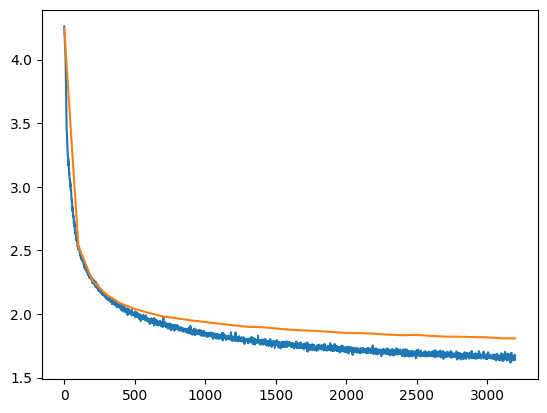

policy loss beta = 1000000, with 100 epochs, and 100 hidden. eval nll ~1.805 for two tokens -> 1.85

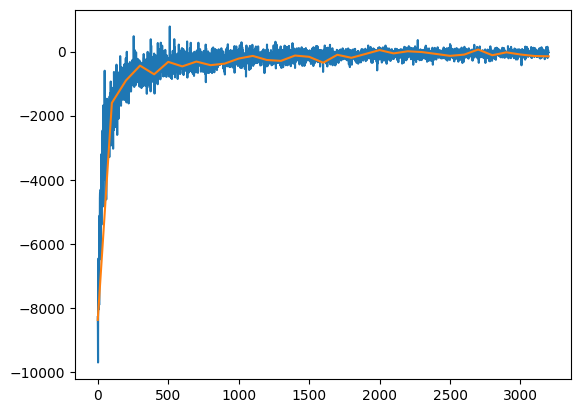

modifying the n_tokens_ahead from 1 to 2 to 16 had no effect. in fact at 16 it performed worse. notably, I don't modify the parameters of the lm head for those future tokens, unlike quiet-star which modifies the parameters of the base language model based on using the hidden representation context vector.

may want to create nll graph and record the mean nll from eval because it is the metric I care about?

when only training with positive rewards above the trice mean, there is a noticable drop in performance:
eval loss 1.97 for both two tokens ahead and 1 token ahead, with policy loss beta 1. For plb 1000000  eval loss 2.07 Could point to substantial optimization room left on the table by not using the negative rewards. (they note this is for stability, so we could fix it with a reference policy (?). Also could use DPO method, but DPO method still needs to be proven that we can train an ok reward model. There are also probably other PPO works which deal with the fact of poor negative reward performance)

get_quiet_star_loss_partial = partial(get_quiet_star_loss, policy_loss_beta=1, trice_samples=2, n_tokens_ahead=1)

train_model(get_nll, lambda model: eval_loss_fn(model, get_quiet_star_loss_partial), QuietStarLanguageModelLSTM(len(vocab), 100, 1, reparameterization_trick=True).to(device), epochs=100)

with reparameterization trick, and just training on NLL loss (because the score function trick isn't required with reparam), we can get eval loss 1.67, further more the avg std goes to about 0.009. This would be the equivelent of a gumbel trick. Doesn't nicely translate to language setting. (but why do they have different performances in the first place? shouldn't the expected gradient be the same? Answer: they are you just need to do more samples in the expectation for the score function trick to get good performance tho. maybe)

can get 1.72 with 10 samples. trying with only positives gets 2.3 very sad! got 1.698 with 20 samples avg std goes to 0.014, normally with 2 it goes to 0.027

For the DPO reward function, we are not just in the single next token setting, we are trying to get an idea of the performance achievable from some given latent representation

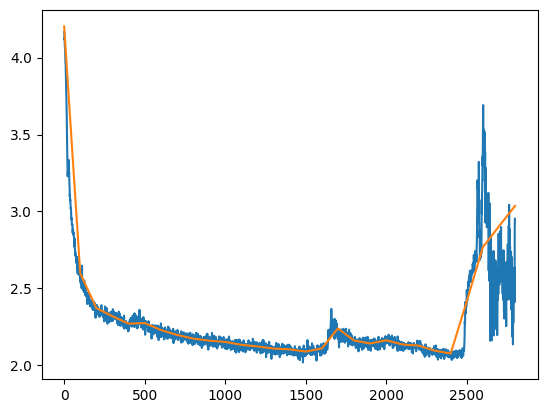

training with tanh after the sampling step. unstable? Had a huge gradient norm near the end. the fix was to add tanh to the activations which determined the distribution activations, this prevented high gradients from flowing backwards from the distribution parameters.

In [11]:
def get_dpo_loss(model: QuietStarLanguageModelrGRU, inputs: torch.Tensor, beta_2: float=1, target_model=None, num_samples=2, dpo_loss_beta:float=1, nll_loss_beta:float=1, forward_kl_reward:bool=True, reward_model=None, train_reward_model=None):
    # need a reward model, or if the other model is defined, I can use this as a reward model, and match with it.
    inputs = inputs.to(device)
    labels = inputs.clone()
    original_batch_size = inputs.size(0)
    repeat_inputs = inputs.repeat_interleave(num_samples, dim=0)
    repeat_labels = labels.repeat_interleave(num_samples, dim=0)
    repeat_logits, repeat_hidden_states, repeat_log_prob_hidden_states, dist = model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(repeat_inputs)
    repeat_log_prob_hidden_states = repeat_log_prob_hidden_states.sum(-1)
    nll_loss = get_nll_from_logits_and_labels(repeat_logits, repeat_labels)
    if target_model is not None:
        '''
        using a pretrained language model as the reward signal implies that I will get the divergence between
        the two langauge models given some prefix. The language model defined by this pretrained model,
        and the language model defined by the current hidden state at this point in the sentence (randomly sampled),
        and implicit to this hidden states predictions over the next tokens is also the parameters of the lm head,
        and the next sampled hidden representations. E_{D(y | x)} E_{pi} [log(D(y | x) / pi(y | h1))], where y is a full trajectory
        KL with this language model, and another?
        Not over real language, but over the proposed next language. For this vocab that is relatively easy only 26 tokens,
        Can probably do 26 ** 4, which is 456976 in size, but the real thing to consider, is that I would have to run
        17576 forward calls, which would take forever, and therefor even for that few vocab size, this is not acceptable.
        Perhaps, if I only focus on some of the generations, like taking a subset, only top 3 tokens per generation, then
        I can do many more tokens ahead for the same compute budget. Not sure if this is a valid approx to the KL.
        Could just do several samples from the target model, and get the log ratio performance over this text in expectation.
        So need a function for computing the KL, first for every partial sequence of inputs,
        I would want to compute continuations with my target LM, then produce a log probability over those samples with the same LM,
        Then produce a log probability with the policy model given the sampled starting state we are trying to evaluate.
        Approximate KL with these log probs, and use as reward. Should be able to achieve good training with this.
        Worst case scenario to verify my implementation at least for the single token scenario, can try to recreate my original
        LSTM experiments with single next token prediction where I saw distribution based KL working as a reward signal.

        Is This KL implementation worth investing time into? What is the overall goal? To test the idea of reward model distillation 
        in place of REINFORCE. This KL implementation made sense in the single next token prediction setting, as the KL was exactly 
        what the reward model was supposed to fit in to have minimal loss, but now, the KL approximates what the reward model should 
        be learning in the first place, and I'm not sure of the quality of the approximation. Before when it was closed form for the true
        reward, it needed to work in order for the next part to work. Now, not so much, might not work, but would really depend on the 
        quality of the KL approximation produced. I could look at the marginal change in KL upon successive increases in number of 
        future tokens, or number of beams for a given prefix, and decide to terminate when the % change is small for all sequence prefixes.
        This would then tell me to be sure of the KL approximation that I am using, in a way I couldn't do with a reward model. 
        Thus again a useful experimental step in guarenteeing the theory that a perfect ish reward model would at least allow for training 
        if this works. Then again, even if it does work, the implication isn't that learning is solved, it is just that reward model distillation
        is a viable alternative to reinforce style algorithms, but this is already proven through AlphaZero. But I guess there is a question on when 
        is it better to try to train with reward model distillation versus policy gradient (REINFORCE) based methods, and that question, I don't 
        answer at all. I think in service of answering this question, I should review more in what people have already said about distillation style 
        methods like with advantage actor critic vs ppo, or looking at control as inference works. I think I am missing something, and I am not 
        confident in the success likelihood of my experiments. Should I keep going till I run into some wall in performance, which I believe can't 
        be surmounted? I now, have some confidence. The Control as inference works, lead me to thinking of AlphaZero works even more, and I 
        think there are some modifications I can make to my setup to make it flexible enough to include AlphaZero style methods, which should work
        (I am however not sure how to tune AlphaZero style methods. I should experiment in a different arena, like that of solved board game agents)
        Trying to solve this directly on my language model setting will just lead to reinventing the wheel? not bad tho, just hard here, and would 
        want some grounding first? Maybe if I hit a wall then I will take time to go back to the basics rather than going to the basics because I 
        think I will hit a wall.

        In light of the similarities between AlphaZero and this method, what would this experiment say in the Alpha zero setting?
        - First of all the actions which I am taking are sampled probabilistically based on my current policy, in alpha zero they are taken based
            on the current reward function and policy with a tree search that calls the reward function multiple times, and builds confidence in 
            the gold action distribution through multiple inference calls. Then based on this confident distribution from the multiple calls to the state 
            eval model with tree search, the distribution to tune on is created. With my proposed solution, there is a clear potential issue with the 
            correctness of my reward function, because I rely on its value from a single inference step across those states which were sampled from 
            the current policy. My more full proposal is to have more models, and quantify the model uncertainty, so as only to train on very confident 
            action pairs. The complexity isn't very high, but I haven't implmented this idea yet.
        - Using a more confident prediction of my true reward created through a KL divergence with a psuedo true language distribution can isolate the 
            reward model's implementation, and tell me about my other algorithm choices like:
            - if the idea of using a state distribution collected from simple on policy model is ok or perhaps some other state distribution 
                would be better like reference model or even AlphaZero style model. (If I say the state distribution is determined by something off policy, 
                then the way I collect data for my reward function must be collected seperately. I already do this here for correctness, but might be less 
                efficient).
            - Also if using actions proposed from the on policy model versus a different model would be best (This gets into iterative DPO considerations).
                Ultimately what we want to be doing is sampling from the gold action distribution, which is the exponential Q distirbution. Alpha Zero 
                does this in a nicer way than simple on policy actions in my opinion, because of the added confidence through multiple reward model forward 
                calls, and using number of visits rather than a simple ratio of average Q values to ensure only the confident predictions are matched, not 
                the overly speculative with no evidence.
        Answer: in the AlphaZero setting the method in general would rewrite the MCTS portion in place of high confidence reward functions to create the distribution 
            over actions, which should be matched by the policy. Having this high confidence reward function with the KL with a psuedo target language distirbution,
            in the AlphaZero setting would let someone designing the alpha zero setting know if their N ^ 1/T distribution over actions is getting closer to the 
            distribution given from this psuedo target langauge distirbution possibly helpful for tuning different parameters in the MCTS stack. 
            
        The distribution should match that of the optimal distribution for your reward or for your value model, so only the Q values which you are confident in work...
        '''
        # raise NotImplementedError("Using a pretrained language model need to implement.")
        with torch.no_grad():
            assert forward_kl_reward, "reverse KL is dropped from support, because it didn't show promise in early experiments."
            # repeat_reward = (torch.softmax(target_model_repeat_logits, dim=-1) * torch.log_softmax(repeat_logits, dim=-1)).sum(-1)
            # need to get so much shit. Just take in for now some defined types, and I know how to play with them. main difficulty is getting target model able to have its hidden representations and use them for generation from the middle of a sentence, and then reshaping the generations to be (batch=batch_parent x num_samples_p x seq_len_p) x num_samples x num_tokens_ahead
            repeat_reward = get_forward_kl_reward_with_target_model(target_model, repeat_inputs, repeat_hidden_states, num_tokens_ahead_of_hidden_representation=10, num_samples_per_hidden_representation=2, model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist)
            # target_model_repeat_logits = target_model(repeat_inputs)
            ...
            # else: # reverse KL didn't show much promise, just ignored what it was getting wrong I think. pretty piss poor exploration. the entropy encouragement beta_2 doesn't really help.
            #     # repeat_reward = (torch.softmax(repeat_logits, dim=-1) * (torch.log_softmax(target_model_repeat_logits, dim=-1) - torch.log_softmax(repeat_logits, dim=-1))).sum(-1)
            #     ...
    elif reward_model is not None and train_reward_model is not None:
        # train the reward model every so often to ensure it remains relevant to the current lm head and hidden state distribution.
        train_reward_model(reward_model, model)
        with torch.no_grad():
            repeat_reward = reward_model(repeat_inputs, repeat_hidden_states)
    else:
        raise ValueError("must define either reward model or target model to train with DPO loss, i.e. need some way to get reward.")
    repeat_reward = repeat_reward.view(original_batch_size, num_samples, -1)
    # this for numerical stability.
    repeat_reward = repeat_reward - repeat_reward.max(dim=1, keepdim=True).values
    repeat_exp_reward = (repeat_reward).exp()
    repeat_gold_action_weight = repeat_exp_reward / repeat_exp_reward.sum(1, keepdim=True)
    repeat_log_prob_hidden_states = repeat_log_prob_hidden_states.view(original_batch_size, num_samples, -1)
    repeat_log_prob_hidden_states_divided_by_max_hidden_state_prob = repeat_log_prob_hidden_states - repeat_log_prob_hidden_states.max(1, keepdim=True).values # need to get the sum of the probabilities in the denominator
    repeat_beta2_log_prob_hidden_states_divided_by_max_hidden_state_prob = beta_2 * repeat_log_prob_hidden_states_divided_by_max_hidden_state_prob
    repeat_log_weight_on_hidden_states = repeat_beta2_log_prob_hidden_states_divided_by_max_hidden_state_prob - repeat_beta2_log_prob_hidden_states_divided_by_max_hidden_state_prob.exp().sum(1, keepdim=True).log()
    dpo_loss = -(repeat_gold_action_weight.detach() * repeat_log_weight_on_hidden_states).sum(1).mean()
    loss = dpo_loss * dpo_loss_beta + nll_loss * nll_loss_beta
    print(f"{dpo_loss= }")
    print(f"{nll_loss= }")
    avg_std = dist.scale.mean()
    print(f"{avg_std= }")
    return loss


In [12]:
# pickle.dump(rnn_lm.cpu(), open("rnn_lm_1.51_eval_1.5_train.pkl", 'wb'))

In [13]:
rnn_lm = pickle.load(open("rnn_lm_1.51_eval_1.5_train.pkl", 'rb')).to(device)

In [ ]:
get_dpo_loss_partial = partial(get_dpo_loss, target_model=rnn_lm, beta_2=0.0001, dpo_loss_beta=10000, num_samples=2)
dpo_trained_model = QuietStarLanguageModelrGRU(len(vocab), 100, 1, model_type = 'rgruh').to(device)
train_model(get_dpo_loss_partial, lambda model: eval_loss_fn(model, get_nll), dpo_trained_model, epochs=100)

best obtainable 1.65 with normal nll 100 hidden dim 100 epochs.  got 1.82 eval with 100 hidden dim, and 100 epochs beta_2 = 0.0001



dpo with beta value 0.0001, no reference model hence the high beta value. eval nll 1.86. with best obtainable 1.5? with normal nll with 1000 hidden dim 100 epochs

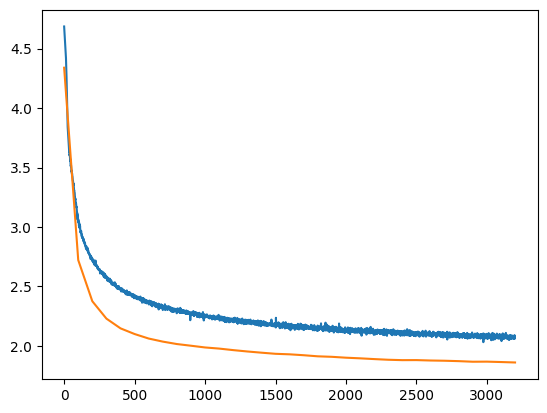



get_dpo_loss_partial = partial(get_dpo_loss, target_model=rnn_lm, beta_2=0.0001, dpo_loss_beta=10000) # ceiling is 1.65. obtained 1.79 matching quiet-star with positive and negative rewards.

train_model(get_dpo_loss_partial, lambda model: eval_loss_fn(model, get_nll), QuietStarLanguageModelLSTM(len(vocab), 100, 1).to(device), epochs=100)


eval 1.738 with ceiling of 1.657 with increase samples. beta_2=0.0001, dpo_loss_beta=10000, num_samples=10. 20 samples gets 1.728

In [13]:
class RewardModel(torch.nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers=1, dim_of_latent=None):
        super().__init__()
        if dim_of_latent is None:
            dim_of_latent = hidden_dim
        self.embed_tokens = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
        self.model = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.output_layer = torch.nn.Linear(in_features=hidden_dim + dim_of_latent, out_features=1)
    def forward(self, token_context, latent_states):
        # produce the expected reward for a particular choice of latent state and context x. right? the expectation is that there is a latent state per token in the token_context tensor
        x = self.embed_tokens(token_context)
        x, _ = self.model(x)
        x = self.output_layer(torch.concat((x, latent_states), dim=-1))
        return x.squeeze(-1)

In [14]:
# pickle.dump(dpo_trained_model.cpu(), open("dpo_trained_model_1.64_eval.pkl", 'wb'))
dpo_trained_model = pickle.load(open("dpo_trained_model_1.64_eval.pkl", 'rb')).to(device)
rnn_lm = pickle.load(open("rnn_lm_1.51_eval_1.5_train.pkl", 'rb')).to(device)


In [ ]:
# collect the input_ids, and latent_states to train off of for the reward model.

# create a function to collect the nlls input_ids and latent states. Could do this in the train model loop with a unique loss function, but I don't need to update the parameters of my model, so I could just create a new loop for this explicit purpose.
def get_data_for_reward_model_training(model: QuietStarLanguageModelLSTM, repeat_sample, sample_for_train):
    train_size = int(len(train_reward_model_dataset_shakespeare) // 10 * 0.9) * 10
    input_and_latent_states_and_labels_dataset_train = []
    input_and_latent_states_and_labels_dataset_eval = []
    for _ in range(repeat_sample):
        i = 0
        for d in torch.utils.data.DataLoader(train_reward_model_dataset_shakespeare, batch_size=10, collate_fn=shakespeare_collate_fn): # no shuffle here can shuffle later if want to.
            d = d.to(device)
            with torch.no_grad():
                logits, hidden_states, _, _ = model.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(d)
                
                shifted_logits = logits[:, :-1].contiguous()
                shifted_input = d[:, :-1]
                shifted_hidden_states = hidden_states[:, :-1].contiguous()
                shifted_labels = d[:, 1:].contiguous()
                is_train_data = i < train_size
                if is_train_data:
                    inputs_to_extend = input_and_latent_states_and_labels_dataset_train
                else:
                    inputs_to_extend = input_and_latent_states_and_labels_dataset_eval
                if sample_for_train and is_train_data:
                    targets = - torch.nn.CrossEntropyLoss(reduction='none')(shifted_logits.view(-1, logits.size(-1)), shifted_labels.view(-1)).view_as(shifted_labels)
                else:
                    # targets can also be decided based on the KL[D_ref(y | x) || policy(y | h)] with a reference policy, this is when we assume the reference policy represents the true data distribution.
                    target_logits = rnn_lm(shifted_input)
                    targets = (torch.softmax(target_logits, dim=-1) * torch.log_softmax(shifted_logits, dim=-1)).sum(-1) # has similar mean to just samples from the data, as expected, but the std between samples is smaller which makes sense, as we remove the variation from sampling and just directly get the expected KL on the distribution provided from the dpo model compared to the rnn_lm.
                i += shifted_input.size(0)
                inputs_to_extend.extend(zip(shifted_input.cpu(), shifted_hidden_states.cpu(), targets.cpu()))
    # I can choose to reward model the dpo models KL with data it was trained on or with data it wasn't trained on? I really need to generalize to the reward of the data we are going to use for training with DPO. 
    # I should not train on that data tho, because then I would learn to give the exact loss achieved on that sample with that hidden state, which has the problem of not being the expected reward for that input/hidden state.
    return input_and_latent_states_and_labels_dataset_train, input_and_latent_states_and_labels_dataset_eval
input_and_latent_states_and_labels_dataset_train, input_and_latent_states_and_labels_dataset_eval = get_data_for_reward_model_training(dpo_trained_model, repeat_sample=10, sample_for_train=True)

In [56]:
labels_from_data_distribution = torch.concat([input_and_latent_states_and_labels_dataset_train[i][-1] for i in range(len(input_and_latent_states_and_labels_dataset_train))])
labels_from_data_distribution.mean(), labels_from_data_distribution.std()

(tensor(-1.6405), tensor(1.4577))

In [ ]:
labels_from_closed_from_kl = torch.concat([input_and_latent_states_and_labels_dataset_eval[i][-1] for i in range(len(input_and_latent_states_and_labels_dataset_eval))])
labels_from_closed_from_kl.mean(), labels_from_closed_from_kl.std()

(tensor(-1.6699), tensor(0.9500))

Number training steps total: 305
eval loss 2.7291702694363065
loss 0     2.7774062156677246
loss 1     2.3098318576812744
loss 2     1.8561772108078003
loss 3     1.5061426162719727
loss 4     1.2220115661621094
loss 5     0.9549753665924072
loss 6     0.7695146799087524
loss 7     0.6432797312736511
loss 8     0.5641867518424988
loss 9     0.5374022126197815
eval loss 0.5519882837931315
loss 10    0.5478295683860779
loss 11    0.5818609595298767
loss 12    0.6107260584831238
loss 13    0.6193346977233887
loss 14    0.6370869874954224
loss 15    0.6021691560745239
loss 16    0.5674903392791748
loss 17    0.5297573804855347
loss 18    0.4988583028316498
loss 19    0.45056289434432983
eval loss 0.4159539010789659
loss 20    0.41295671463012695
loss 21    0.38520535826683044
loss 22    0.36624735593795776
loss 23    0.35001081228256226
loss 24    0.3358851671218872
loss 25    0.3260577321052551
loss 26    0.32394763827323914
loss 27    0.3230610489845276
loss 28    0.3115394115447998
loss

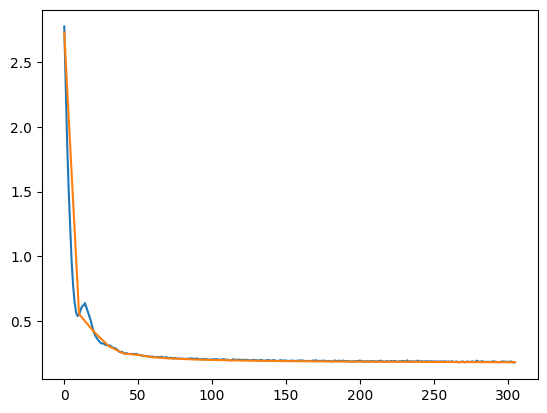

In [ ]:
# Could change the data loader change the inputs and labels for this setting as it is no longer a language modeling setting, but a reward modeling setting.
# should modify them so that inputs is context text and hidden_state chosen, and labels is what the correct (instant or expected) reward should have been
def get_reward_model_loss(model: RewardModel, inputs: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
    # expect to find input_ids, and a latent_states of similar dimension plus the dimension of the hidden state for the language model which produced the latent.
    # get_logits_and_hidden_states
    input_ids, latent_states, labels = inputs
    input_ids, latent_states, labels = input_ids.to(device), latent_states.to(device), labels.to(device)
    predicted_rewards = model(input_ids, latent_states)
    diffs = labels - predicted_rewards
    # print(f"{labels= }")
    # print(f"{predicted_rewards= }")
    # print(f"{diffs= }")
    loss = 0.5 * (diffs).square().mean()
    return loss
def train_reward_model(reward_model, model, repeat_sample, sample_for_train, print_stuff):
    input_and_latent_states_and_labels_dataset_train, input_and_latent_states_and_labels_dataset_eval = get_data_for_reward_model_training(model, repeat_sample=repeat_sample, sample_for_train=sample_for_train)
    train_model(get_reward_model_loss, 
                lambda model: eval_loss_fn(model, get_reward_model_loss, dataloader=torch.utils.data.DataLoader(input_and_latent_states_and_labels_dataset_eval, batch_size=256)), 
                reward_model, 
                epochs=100,
                train_dl=torch.utils.data.DataLoader(input_and_latent_states_and_labels_dataset_train, batch_size=256, shuffle=True),
                eval_every=10,
                print_stuff=print_stuff) # strange observation we aren't over fitting at all? This is nice I guess, but we should be able to overfit if we want to. I did 1000 hidden state, and tried 30 epochs, nothing.
# we converge quickly, but is it to a good value? mse 0.7 for samples or 0.18 to the closed KL to reference model. Some of the rewards are very far off actually, not sure if this will be useful. 
# Will try first to use it in DPO, if doesn't work will then move to train ensemble. # matches eval 0.23 when trained on samples of log likelihood and matches eval to 0.17 when trained from the KL
train_reward_model(RewardModel(len(vocab), hidden_dim=100).to(device), dpo_trained_model, repeat_sample=10, sample_for_train=False, print_stuff=True)

Number training steps total: 2800
eval loss 4.336419582366943
Number training steps total: 40
eval loss 9.647443771362305
loss 0     9.659393310546875
loss 1     9.393880844116211
loss 2     9.164434432983398
loss 3     8.995941162109375
loss 4     8.695518493652344
loss 5     8.451360702514648
loss 6     8.15606689453125
loss 7     8.059782981872559
loss 8     7.59528923034668
loss 9     7.285473823547363
eval loss 6.952795028686523
loss 10    6.901096343994141
loss 11    6.999740123748779
loss 12    6.0428996086120605
loss 13    5.559576034545898
loss 14    4.997659683227539
loss 15    5.322469711303711
loss 16    3.710531711578369
loss 17    3.0752735137939453
loss 18    2.4951343536376953
loss 19    3.587360382080078
eval loss 1.6079705953598022
loss 20    1.4478669166564941
loss 21    1.098055362701416
loss 22    0.8249633312225342
loss 23    2.082962989807129
loss 24    0.4383693337440491
loss 25    0.3284553289413452
loss 26    0.2810075879096985
loss 27    1.1991065740585327
lo

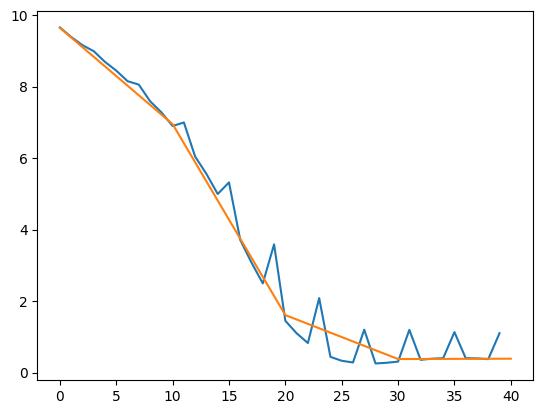

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(4.3333, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
loss 0     6935.806640625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(4.3269, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1     6935.79833984375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(4.3243, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
loss 2     6935.7919921875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(4.3141, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
loss 3     6935.7841796875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(4

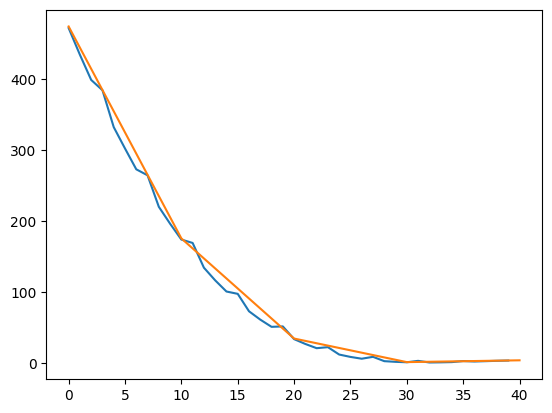

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.5033, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(1.4140, device='cuda:0', grad_fn=<MeanBackward0>)
loss 100   6934.97412109375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4855, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(1.4191, device='cuda:0', grad_fn=<MeanBackward0>)
loss 101   6934.9560546875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.5155, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
loss 102   6935.0029296875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4971, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(1.4310, device='cuda:0', grad_fn=<MeanBackward0>)
loss 103   6934.96484375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.

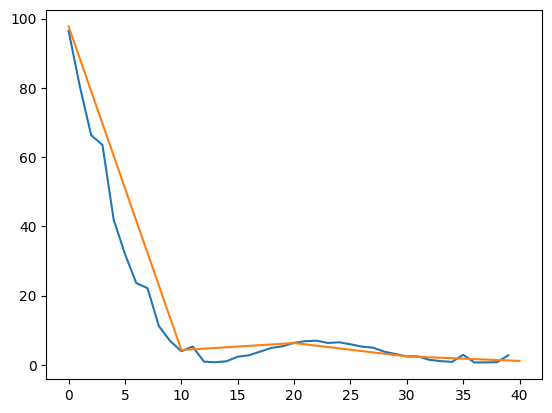

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4434, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(2.1414, device='cuda:0', grad_fn=<MeanBackward0>)
loss 200   6934.91650390625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4597, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(2.1480, device='cuda:0', grad_fn=<MeanBackward0>)
loss 201   6934.9423828125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4519, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(2.1563, device='cuda:0', grad_fn=<MeanBackward0>)
loss 202   6934.92138671875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4538, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(2.1654, device='cuda:0', grad_fn=<MeanBackward0>)
loss 203   6934.9267578125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor

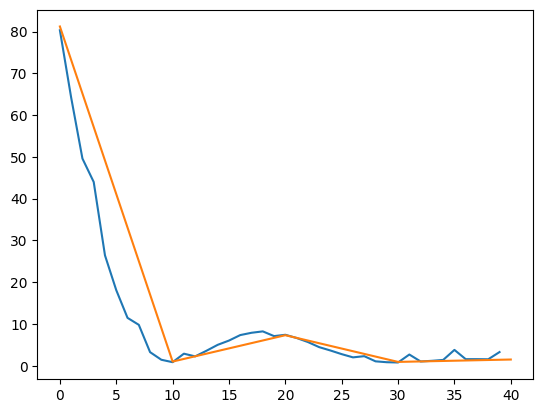

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4454, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.1172, device='cuda:0', grad_fn=<MeanBackward0>)
loss 300   6934.9208984375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4553, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.1711, device='cuda:0', grad_fn=<MeanBackward0>)
loss 301   6934.92236328125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4247, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.2254, device='cuda:0', grad_fn=<MeanBackward0>)
loss 302   6934.89794921875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4381, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.2850, device='cuda:0', grad_fn=<MeanBackward0>)
loss 303   6934.8955078125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor

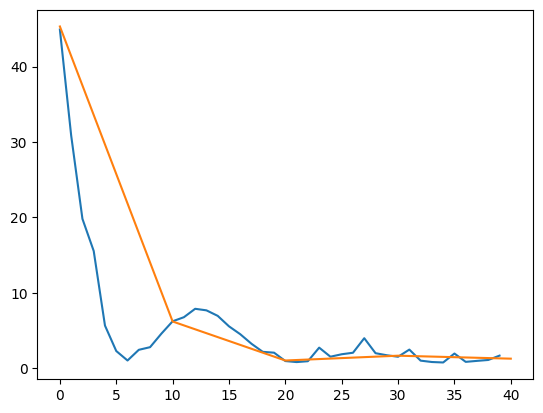

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4154, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.8795, device='cuda:0', grad_fn=<MeanBackward0>)
loss 400   6934.875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4394, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.8760, device='cuda:0', grad_fn=<MeanBackward0>)
loss 401   6934.921875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4320, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.8721, device='cuda:0', grad_fn=<MeanBackward0>)
loss 402   6934.91650390625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4176, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(4.8627, device='cuda:0', grad_fn=<MeanBackward0>)
loss 403   6934.88525390625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.4418, de

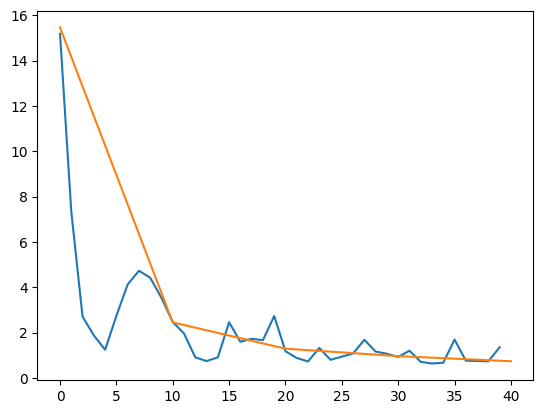

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3685, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(5.7613, device='cuda:0', grad_fn=<MeanBackward0>)
loss 500   6934.85107421875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3656, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(5.7637, device='cuda:0', grad_fn=<MeanBackward0>)
loss 501   6934.822265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3825, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(5.7581, device='cuda:0', grad_fn=<MeanBackward0>)
loss 502   6934.84619140625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3544, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(5.7580, device='cuda:0', grad_fn=<MeanBackward0>)
loss 503   6934.8095703125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(

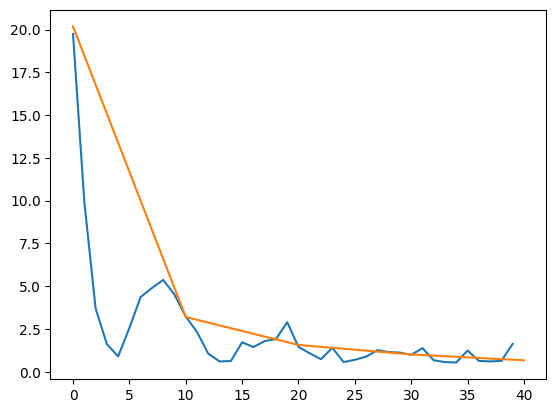

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3487, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.0145, device='cuda:0', grad_fn=<MeanBackward0>)
loss 600   6934.82421875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3830, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.0341, device='cuda:0', grad_fn=<MeanBackward0>)
loss 601   6934.84326171875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3613, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.0489, device='cuda:0', grad_fn=<MeanBackward0>)
loss 602   6934.822265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3783, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.0565, device='cuda:0', grad_fn=<MeanBackward0>)
loss 603   6934.8515625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3527

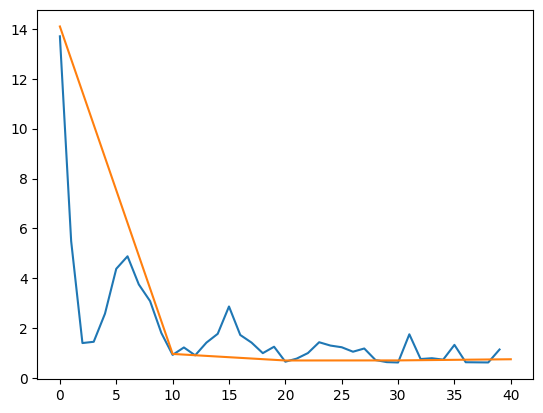

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3651, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.4121, device='cuda:0', grad_fn=<MeanBackward0>)
loss 700   6934.84521484375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3676, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.4201, device='cuda:0', grad_fn=<MeanBackward0>)
loss 701   6934.82958984375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3474, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.4237, device='cuda:0', grad_fn=<MeanBackward0>)
loss 702   6934.80029296875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3481, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(6.4159, device='cuda:0', grad_fn=<MeanBackward0>)
loss 703   6934.83056640625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tens

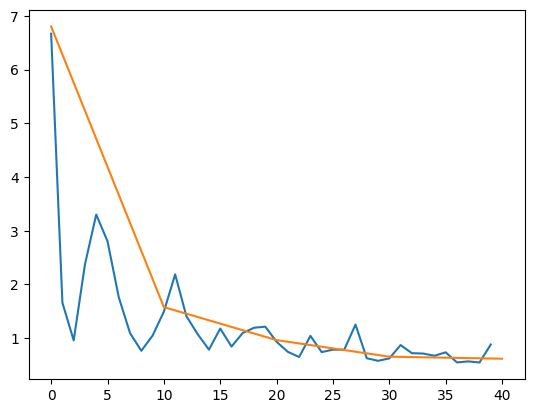

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3515, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(9.0683, device='cuda:0', grad_fn=<MeanBackward0>)
loss 800   6934.822265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3414, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(9.1237, device='cuda:0', grad_fn=<MeanBackward0>)
loss 801   6934.8095703125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3514, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(9.1881, device='cuda:0', grad_fn=<MeanBackward0>)
loss 802   6934.82177734375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3733, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(9.2487, device='cuda:0', grad_fn=<MeanBackward0>)
loss 803   6934.857421875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.

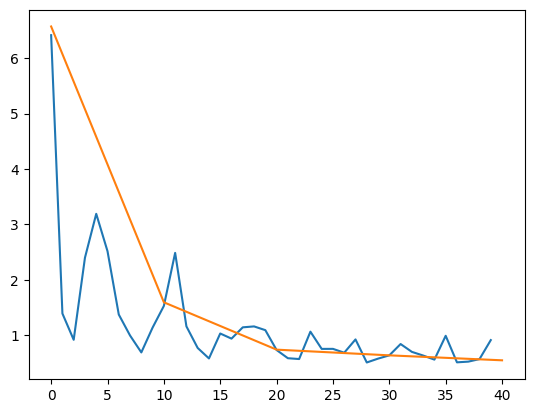

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3698, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.2543, device='cuda:0', grad_fn=<MeanBackward0>)
loss 900   6934.83447265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3524, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.2688, device='cuda:0', grad_fn=<MeanBackward0>)
loss 901   6934.8125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3349, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.2811, device='cuda:0', grad_fn=<MeanBackward0>)
loss 902   6934.80859375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3336, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.2907, device='cuda:0', grad_fn=<MeanBackward0>)
loss 903   6934.80078125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3461

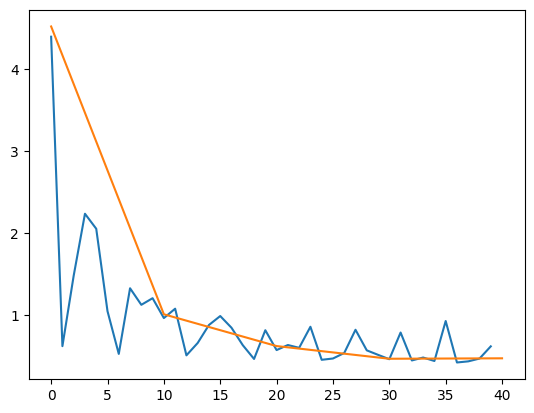

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3482, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.7844, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1000  6934.8193359375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3397, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.7684, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1001  6934.80322265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3550, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.7404, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1002  6934.82080078125
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3454, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(12.7082, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1003  6934.822265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= ten

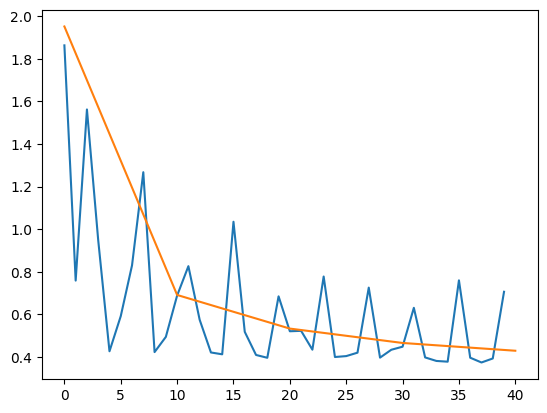

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3403, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(14.1597, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1100  6934.810546875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3575, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(14.1984, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1101  6934.8232421875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3455, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(14.2299, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1102  6934.8134765625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3414, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(14.2544, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1103  6934.80712890625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tens

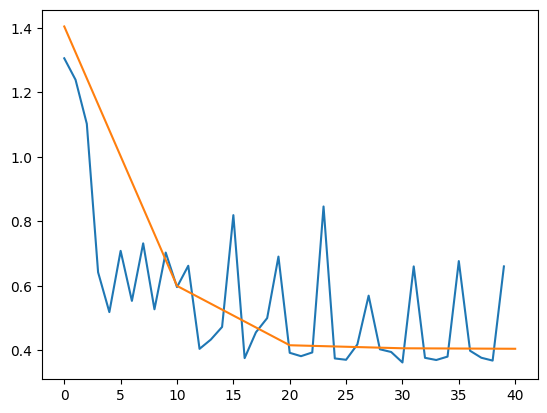

dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3481, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(15.9171, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1200  6934.82177734375
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3650, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(15.9104, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1201  6934.83447265625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3463, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(15.9014, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1202  6934.82421875
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= tensor(3.3334, device='cuda:0', grad_fn=<NllLossBackward0>)
avg_std= tensor(15.9066, device='cuda:0', grad_fn=<MeanBackward0>)
loss 1203  6934.79541015625
dpo_loss= tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)
nll_loss= ten

KeyboardInterrupt: 

In [40]:
reward_model = RewardModel(len(vocab), hidden_dim=100).to(device)
num_calls_trainer = 0
def train_reward_model_partial(reward_model, model):
    global num_calls_trainer
    if num_calls_trainer % 100 == 0:
        num_calls_trainer += 1
        return train_reward_model(reward_model, model, sample_for_train=False, print_stuff=True)
    else:
        num_calls_trainer += 1
        return None # train_reward_model(reward_model, model, sample_for_train=False, print_stuff=False)
get_dpo_loss_partial = partial(get_dpo_loss, beta_2=0.0001, dpo_loss_beta=10000, num_samples=2, reward_model=reward_model, train_reward_model=train_reward_model_partial)
dpo_trained_model_with_reward_model = QuietStarLanguageModelLSTM(len(vocab), 100, 1).to(device)
train_model(get_dpo_loss_partial, lambda model: eval_loss_fn(model, get_nll), dpo_trained_model_with_reward_model, epochs=100)

# Transformer implementation of quiet-star from base generative model using the generate primative

I need to remove the @torch.no_grad() torch decorator on generate when calling generate in the quiet-star setting of multiple thoughts in parallel. [remove decorator](https://discuss.huggingface.co/t/how-to-output-loss-from-model-generate/16999/10)

Need to figure out how I can do the tricks they do with the kv cache and the position ids and the attention mask in the setting where I am not redefining the forward pass, just the generate function. Is there anything that should stop this?? Worst case, I divert to doing it in the forward function of whatever model I decide to use as the basic transformer unit, and I just stick with that, which isn't so bad.

Need to define a new update model kwargs for generation as the attention mask shouldn't just be appended with new ones, but should be appended with new diagonal of ones, which correspond to the fact that seq len thought tokens are being generated not just a single token. batch * seq x seq is how it will look. Also the cache position is updated to only have the single next token, but I need to have the position ids for all new tokens updated, which would mean for parallel generation to have cache position updated and maintained for every marginal token. Essentially all I am doing here is just factoring the generation code out of the forward pass so when I experiment I will be able to switch models quickly. Is there any other benefit? (I don't know how much I will switch from gpt2 in my testing??)

Plaid did scaling experiments, I don't think I should start working this in unless that is what I am aiming to do. Study the effect of scaling reasoning model vs performance in NLL task, but right now I think I just want to focus on showing that training with NLL for reasoning can help over training with just varifiable rewards. (The subtext is I should verify that the settings I think aren't helped by cot are also not helped by the reasoning trained models.) Or I guess, there are other things that I can show. The burden of usefulness isn't that this is AGI or can even that it is already better than verifiable rewards.

In [2]:
# from quiet_star_replicate.model.model import 
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model, GenerationConfig, GenerationMixin, PreTrainedModel
model = AutoModelForCausalLM.from_pretrained('gpt2').cuda()
tokenizer = AutoTokenizer.from_pretrained("gpt2")


In [3]:
GPT2Model, GenerationConfig  # something akin to parallel sampling of the hidden representation from an RNN.

(transformers.models.gpt2.modeling_gpt2.GPT2Model,
 transformers.generation.configuration_utils.GenerationConfig)

In [25]:
inputs = tokenizer("hello there world what is going updog?", return_tensors='pt')
inputs.to('cuda')
# print(inputs)
original_model_outputs = model(**inputs)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model, GenerationConfig, GenerationMixin, PreTrainedModel, GPT2LMHeadModel
from transformers.models.gpt2.modeling_gpt2 import BaseModelOutputWithPastAndCrossAttentions # I can also try importing this from its root of transformers.modeling_outputs, maybe later.

# I need to rewrite the GPT2Model, and then for the GPT2LMHeadModel, I need to change the init function, replacing their GPT2 with my Custom one.
from quiet_star_replicate.model.model import CustomGPT2LMHeadModel


model = AutoModelForCausalLM.from_pretrained('gpt2').cuda()
tokenizer = AutoTokenizer.from_pretrained("gpt2")
cmodel = CustomGPT2LMHeadModel.from_pretrained('gpt2').cuda()
# now I need to verify that the model's forward pass is the same if I use a custom causal mask. Just for sanity check.


In [7]:
import torch
x = torch.arange(100).reshape(1,-1).cuda()
cmodel(x).logits

tensor([[[ -37.7549,  -38.2652,  -40.4860,  ...,  -47.3887,  -46.8042,
           -36.8606],
         [ -69.7059,  -68.8305,  -68.4345,  ...,  -75.0572,  -74.2559,
           -64.0605],
         [ -50.3636,  -47.9540,  -51.2161,  ...,  -63.0638,  -60.9918,
           -52.0684],
         ...,
         [-122.1920, -122.3659, -122.4192,  ..., -138.6439, -136.6422,
          -126.9874],
         [-126.1728, -126.1284, -126.1772,  ..., -142.4052, -140.7815,
          -130.9767],
         [-122.3258, -122.2993, -122.2788,  ..., -137.8327, -136.6277,
          -126.9115]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [48]:
import torch
torch.set_grad_enabled(True)
# generation_output = model.generate(**inputs, return_dict_in_generate=True, output_scores=True)
from quiet_star_replicate.model.model import sample_thoughts, prepare_shifted_inputs_for_thought_sampling_and_next_token_prediction_for_loss, use_thoughts_to_get_loss_over_next_tokens
# sample_thoughts
# I want the model to be able to take in a binary mask that makes sense, 
# and then do the thing to convert it without having the code know how to do the conversion, 
# as this is model specific
from quiet_star_replicate.model.model import invert_and_maxfloat_attn_mask
def call_cmodel(*args, **kwargs):
    if len(args) > 2:
        attention_mask = args[2]
        attention_mask = invert_and_maxfloat_attn_mask(attention_mask, dtype=cmodel.transformer.wte.weight.dtype)
        args = tuple(arg if i != 2 else attention_mask for i, arg in enumerate(args))
    elif 'attention_mask' in kwargs:
        attention_mask = kwargs.pop('attention_mask')
        attention_mask = invert_and_maxfloat_attn_mask(attention_mask, dtype=cmodel.transformer.wte.weight.dtype)
        kwargs['attention_mask'] = attention_mask
    return cmodel(*args, **kwargs)
thought_len_max = 10
num_tokens_ahead =  2
start_of_thought_token_id = 0
end_of_thought_token_id = 0
vocab_size = cmodel.config.vocab_size
inputs_for_thought_sampling, inputs_for_next_token_prediction = prepare_shifted_inputs_for_thought_sampling_and_next_token_prediction_for_loss(inputs['input_ids'], thought_len_max, num_tokens_ahead)

sampled_thoughts_outputs = sample_thoughts(call_cmodel, inputs_for_thought_sampling, start_of_thought_token_id, thought_len_max)
_, _, _, (kv_cache, last_attention_mask) = sampled_thoughts_outputs
next_token_prediction_loss_outputs = use_thoughts_to_get_loss_over_next_tokens(call_cmodel, inputs_for_next_token_prediction, vocab_size, kv_cache, last_attention_mask, end_of_thought_token_id, num_tokens_ahead)

next_token_prediction_loss_outputs
# there were 7 thoughts generated, for a sequence of 9 tokens, one for each of index 0 through 6. 
# not for index 7 and 8 because they wouldn't have enough tokens for calculating loss.
# now I can use the loss as reward signal, just need to produce more thoughts per index, and then apply REINFORCE
# I should use mean on this thing for the signal.

tensor([[[ 8.8502, 12.1225],
         [14.0835,  9.8033],
         [ 9.8304,  3.1705],
         [ 8.4287,  4.6075],
         [11.5574, 14.4477],
         [17.0689,  5.0793],
         [13.1103,  6.1853]]], device='cuda:0', grad_fn=<StackBackward0>)

In [46]:
# def test_use_thoughts_to_get_loss_over_next_tokens(model, labels: torch.Tensor, vocab_size, num_tokens_ahead: int):
#     batch_size = labels.size(0)
#     input_seq_len = labels.size(1) - num_tokens_ahead
#     input_ids = labels[:, :input_seq_len] # [batch, input_seq_len]
#     past_key_values = None
#     attention_mask = torch.tril(torch.ones((input_seq_len,input_seq_len), device=input_ids.device, dtype=torch.long))[None, None, ...]  # covers: [batch, n_heads, seq, seq]
#     position_ids = get_position_ids_from_attn_mask(attention_mask, batch_size) # [batch, seq]

#     log_prob_next_tokens_list = []
#     for i in range(1, num_tokens_ahead + 1):
#         outputs = model(input_ids=input_ids, past_key_values=past_key_values, attention_mask=attention_mask, position_ids=position_ids, use_cache=True)
#         past_key_values = outputs.past_key_values
#         position_ids, attention_mask = prepare_output_for_next_input(attention_mask, batch_size)
#         log_prob_next_tokens_list.append(
#             torch.nn.functional.cross_entropy(
#                 outputs.logits.view(-1, vocab_size), 
#                 labels[:, i: i + input_seq_len].view(-1), 
#                 reduction='none')
#             .reshape(input_ids.shape))
#         if i == num_tokens_ahead: # can't feed the model anything more to predict after this point, so should stop.
#             ...
#         else:
#             # here we load up the next inputs to feed into the model
#             input_ids = labels[:, i: i + input_seq_len] # [batch, seq_len]
#     log_prob_next_tokens = torch.stack(log_prob_next_tokens_list, dim=2)# batch, seq_len, num_tokens_ahead
    
#     kv_cache = past_key_values
#     last_attention_mask = attention_mask
#     return log_prob_next_tokens, kv_cache, last_attention_mask
# test_use_thoughts_to_get_loss_over_next_tokens(call_cmodel, inputs['input_ids'], vocab_size, num_tokens_ahead)
# tensor([[[ 6.7073, 12.4600],
#           [12.4600,  7.2178],
#           [ 7.2178,  2.8467],
#           [ 2.8467,  2.9630],
#           [ 2.9630, 19.0911],
#           [19.0911,  4.7390],
#           [ 4.7390,  2.6030]]] This result is what I wanted, just to show I was feeding the next tokens in correctly.
# tensor([ 6.7073, 12.4600,  7.2178,  2.8467,  2.9630, 19.0911,  4.7390,  2.6031], This is from the huggingface impelementation with reduction 'none'

In [39]:
model(inputs['input_ids'], labels=inputs['input_ids']).loss

tensor(7.3285, device='cuda:0', grad_fn=<NllLossBackward0>)

In [42]:
torch.nn.functional.cross_entropy(model(inputs['input_ids']).logits[:, :-1, :].reshape(-1, vocab_size), inputs['input_ids'][:,1:].reshape(-1), reduction='none')

tensor([ 6.7073, 12.4600,  7.2178,  2.8467,  2.9630, 19.0911,  4.7390,  2.6031],
       device='cuda:0', grad_fn=<NllLossBackward0>)

In [22]:
cmodel.config.vocab_size

50257

In [28]:
chosen_token_indices, log_prob_chosen_tokens, prob_dist_over_thought_tokens, kv_cache, last_attention_mask = sampled_thoughts_outputs
chosen_token_indices.shape, log_prob_chosen_tokens.shape, prob_dist_over_thought_tokens.shape, kv_cache[0][0].shape, last_attention_mask.shape

(torch.Size([1, 7, 10]),
 torch.Size([1, 7, 10]),
 torch.Size([1, 7, 10, 50257]),
 torch.Size([1, 12, 84, 64]),
 torch.Size([1, 1, 7, 91]))

In [ ]:
custom_model_outputs = cmodel(input_ids=inputs['input_ids'], 
                              attention_mask=invert_and_maxfloat_attn_mask(torch.tensor([[[
                                                             [1, 0, 0],
                                                             [1, 1, 0],
                                                             [1, 1, 1]]]], device='cuda'),
                                                             dtype=cmodel.transformer.wte.weight.dtype))
custom_model_outputs_qs = cmodel(input_ids=inputs['input_ids'], 
                                 past_key_values=custom_model_outputs.past_key_values,
                                 attention_mask=invert_and_maxfloat_attn_mask(torch.tensor([[[
                                                             [1, 0, 0, 1, 0, 0],
                                                             [1, 1, 0, 0, 1, 0],
                                                             [1, 1, 1, 0, 0, 1]]]], device='cuda'),
                                                             dtype=cmodel.transformer.wte.weight.dtype))

In [30]:
custom_model_outputs_qr = cmodel(input_ids=inputs['input_ids'], 
                                 past_key_values=custom_model_outputs.past_key_values,
                                 attention_mask=invert_and_maxfloat_attn_mask(torch.tensor([[[
                                                             [1, 0, 0, 1, 0, 0],
                                                             [1, 1, 0, 0, 1, 0],
                                                             [1, 1, 1, 0, 1, 1]]]], device='cuda'),
                                                             dtype=cmodel.transformer.wte.weight.dtype))

# Check when the model should do reasoning. 

Record the entropy of predictions on shakespeare dataset.

In [1]:
import torch
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
torch.set_grad_enabled(False)


In [4]:
(glob.glob("../quiet_star_replicate_runs/*seed=1*2025-03-11/*/model.pt"))


['../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\\[gru pretrain v0\\]_max_reasoning_len=0_reasoner_hidden_dim=256_seed=1_2025-03-11/11-44-10/model.pt',
 '../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\\[gru\\ pretrain\\ v0\\]_reasoner_hidden_dim=256_seed=1_2025-03-11/00-13-13/model.pt']

In [ ]:
GRUReasoner256InterpreterMix0LM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\[gru\ pretrain\ v0\]_reasoner_hidden_dim=256_seed=1_2025-03-11/00-13-13/model.pt',map_location=torch.device('cpu'))
# GRUReasoner256InterpreterMix1Ent00016Len50lenpen0001LM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUVarLenScaleExperiment]_entropy_encouragement_coef=0.0016_info=\[varlen\ gru\ v1\ ent\ m1m2\ ent\]_length_penalty=0.001_max_reasoning_len=50_mix_interpeter_base_lm=1_reasoner_hidden_dim=256_seed=1_2025-03-05/00-13-22/model.pt')
# GRUReasoner256InterpreterMix1Ent00016Len10LM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUVarLenScaleExperiment]_entropy_encouragement_coef=0.0016_info=\[varlen\ gru\ v1\ ent\ m1m2\ ent\]_max_reasoning_len=10_mix_interpeter_base_lm=1_reasoner_hidden_dim=256_seed=1_2025-03-04/23-55-53/model.pt")
# GRUReasoner100InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_info=\[varlen\ gru\]_policy_loss_beta=1_punish_unfinished=0.001_reasoner_hidden_dim=100_seed=2_variable_len=True_2025-02-24/23-59-01/model.pt')
# GRUReasoner256InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_info=\[varlen\ gru\]_policy_loss_beta=1_punish_unfinished=0_reasoner_hidden_dim=256_seed=2_variable_len=True_2025-02-24/23-59-01/model.pt')
# GRUReasoner256InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_info=\[varlen\ gru\]_policy_loss_beta=1_punish_unfinished=0.004_reasoner_hidden_dim=256_seed=8_variable_len=True_2025-02-25/02-58-30/model.pt')


<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_1054339/1014458323.py:1: SyntaxWarning: invalid escape sequence '\['
  GRUReasoner256InterpreterMix0LM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\[gru\ pretrain\ v0\]_reasoner_hidden_dim=256_seed=1_2025-03-11/00-13-13/model.pt',map_location=torch.device('cpu'))
/tmp/ipykernel_1054339/1014458323.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during 

In [6]:
GRUReasoner256InterpreterMix0BaseLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\[gru pretrain v0\]_max_reasoning_len=0_reasoner_hidden_dim=256_seed=1_2025-03-11/11-44-10/model.pt', map_location=torch.device('cpu'))
# GRUReasoner256InterpreterMix1BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUVarLenScaleExperiment]_info=\[varlen\ gru\ v1\ ent\ m1m2\]_max_reasoning_len=0_mix_interpeter_base_lm=1_reasoner_hidden_dim=256_seed=4_2025-03-03/23-52-41/model.pt")
# GRU32BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_info=\[varlen\ gru\]_policy_loss_beta=1_punish_unfinished=1_reasoner_hidden_dim=256_seed=3_variable_len=True_2025-02-24/23-59-01/model.pt")
# GRU256BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_info=\[varlen\ gru\]_policy_loss_beta=1_punish_unfinished=1_reasoner_hidden_dim=256_seed=3_variable_len=True_2025-02-24/23-59-01/model.pt")


<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_1054339/1213874750.py:1: SyntaxWarning: invalid escape sequence '\['
  GRUReasoner256InterpreterMix0BaseLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUConcatExperiment]_base_lm_hidden_dim=32_infer_pretrained_reasoner=False_info=\[gru pretrain v0\]_max_reasoning_len=0_reasoner_hidden_dim=256_seed=1_2025-03-11/11-44-10/model.pt', map_location=torch.device('cpu'))
/tmp/ipykernel_1054339/1213874750.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that co

In [5]:
# GRU32BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment,GLMRunConfig]_base_lm_hidden_dim=32_dataset=fw_max_steps=2700_seed=4_2025-02-24/01-57-27/model.pt")
# GRU100BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment,GLMRunConfig]_base_lm_hidden_dim=100_dataset=fw_max_steps=2700_seed=4_2025-02-24/01-57-27/model.pt")
# GRU256BaseLM = torch.load("../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment,GLMRunConfig]_base_lm_hidden_dim=256_dataset=fw_max_steps=2700_seed=4_2025-02-24/01-57-27/model.pt")
# GRUReasoner32InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_dataset=fw_max_steps=2700_policy_loss_beta=1_reasoner_hidden_dim=32_seed=4_use_reasoner=True_2025-02-23/18-43-05/model.pt')
# GRUReasoner100InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_dataset=fw_max_steps=2700_policy_loss_beta=1_reasoner_hidden_dim=100_seed=4_use_reasoner=True_2025-02-23/18-43-05/model.pt')
# GRUReasoner256InterpreterLM = torch.load('../quiet_star_replicate_runs/+run_modifier=[GRUShakeSeparateScaleExperiment]_dataset=fw_max_steps=2700_policy_loss_beta=1_reasoner_hidden_dim=256_seed=4_use_reasoner=True_2025-02-23/18-43-05/model.pt')

# GRUReasoner256InterpreterLM.variable_len = False
# GRUReasoner256InterpreterLM.model.variable_len = False
# GRUReasoner256InterpreterLM.model.pad_token = -1

In [9]:
# plan is to look at the validation set to see which tokens reasoning helps, as well as what reasoning looks like.
from quiet_star_replicate.data.data import FWDataset
from torch.utils.data import Dataset, DataLoader, random_split
from quiet_star_replicate.data.data import CustomTokenizer, get_train_val_test_datasets, get_shakespeare_collate_fn, FWDataset
if True:
    fw_dataset = FWDataset.load("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/", seq_len=128)
    tokenizer = CustomTokenizer.load("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/", 'fwv2')
    train_ds, val_ds, test_ds = random_split(fw_dataset, [0.8, 0.0001, 0.2 - 0.0001], generator=torch.Generator().manual_seed(42))
    start_of_thought_token_id = tokenizer.add_token("<sot>")
    pad_token_id = tokenizer.add_token("<pad>")
    collate_fn = get_shakespeare_collate_fn(tokenizer)

else:
    data_str = open(os.path.join("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/",'./tiny_shakespeare.txt'), 'r').read()
    tokenizer = CustomTokenizer(data_str)
    train_ds, val_ds, test_ds = get_train_val_test_datasets(data_str, seq_len=128)
    collate_fn = get_shakespeare_collate_fn(tokenizer)

val_dl = DataLoader(val_ds, batch_size=1, collate_fn=collate_fn, shuffle=False, num_workers=0)
# for variable length



token already present
token already present


In [12]:
from collections import defaultdict
# temp fix to make tokenizer work for current model. 
# I have to remove the unk token from index 1 because this is how the model was trained.
from copy import deepcopy
reasoning_tokenizer = deepcopy(tokenizer)
# if tokenizer.vocab[1] == '<unk>':
#     tokenizer.vocab.pop(1)
#     tokenizer.index_to_char_list = tokenizer.vocab
#     tokenizer.char_to_index_dict = dict((c, i) for i, c in enumerate(tokenizer.index_to_char_list))
#     tokenizer.char_to_index_dict = defaultdict(tokenizer.get_unk_token_id, tokenizer.char_to_index_dict)
#     tokenizer.index_to_char_list = defaultdict(lambda: '<unk>', dict(enumerate(tokenizer.vocab)))

In [8]:
# GRUReasoner256InterpreterMix1Ent00016Len50lenpen0001LM.model.pad_token = tokenizer.char_to_index_dict['<pad>']
# GRUReasoner256InterpreterMix1Ent00016Len50lenpen0001LM.model.start_of_thought_token = tokenizer.char_to_index_dict['<sot>']

0
['<bos>this one is called Konkonte (with groundnut soup) and it is one of my favorites so far!! It’s deliciousssssssssssssssssss\nWhat e']


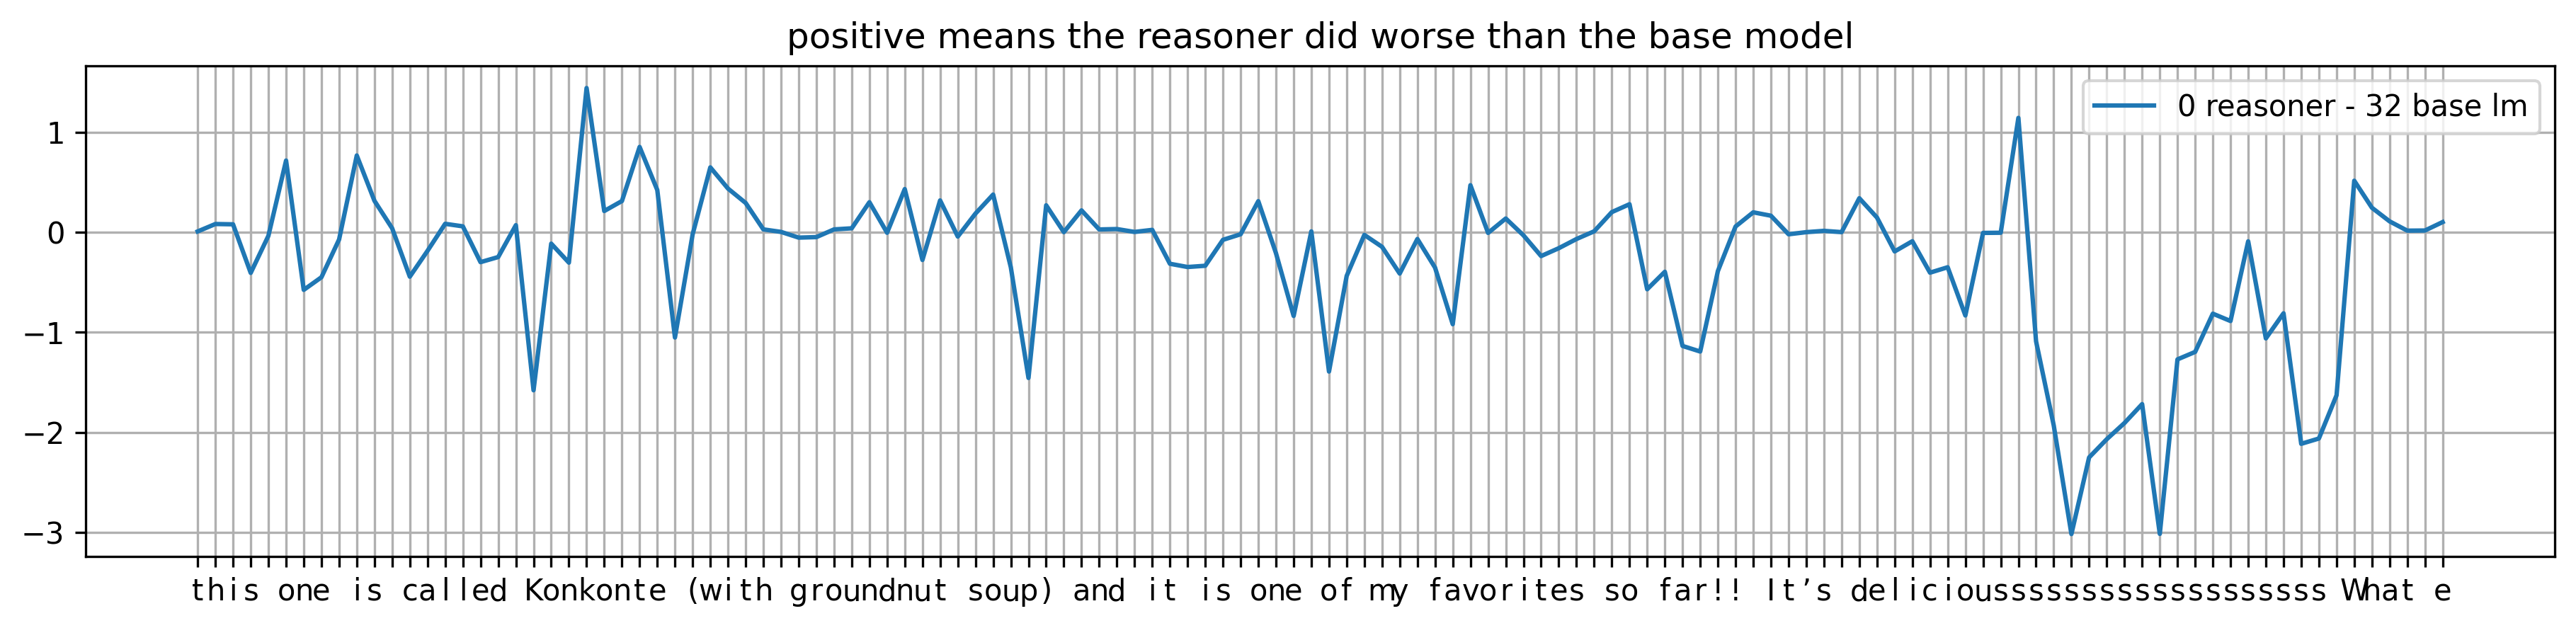

[92, 603, 92, 603, 92, 603, 92, 603, 92, 603]
[('t', ' et', 'y一y一y一y一y一', ' et', 0.9998350143432617, 0.00019735316163860261),
 ('h', 'h e', 'yлyлyлyлyл', 'h i', 0.9941691160202026, 0.0049901241436600685),
 ('i', 'e a', 'yиyиyиyиyи', 'e a', 0.9991058111190796, 0.0008992379298433661),
 ('s', 'snc', '½y�y�y�y�y', 'nsc', 0.9999442100524902, 7.215439836727455e-05),
 (' ', ' ,.', 'yyyyyyyyyy', ' ,.', 0.6508124470710754, 0.18742312490940094),
 ('o', 'ipw', '아î¨ع¨ع¨ع¨ع', 'isw', 0.9594883918762207, 0.025606587529182434),
 ('n', 'nfw', 'Ç♡Ç♡Ç♡γ¨♡Â', 'fnr', 0.005828613415360451, 0.3808559775352478),
 ('e', 'el ', 'บบบบบบบบบบ', ' el', 1.0, -0.0),
 (' ', ' s-', 'yบyบyบyบyบ', ' -s', 0.9989986419677734, 0.0009571307455189526),
 ('i', 'otw', '一要一要一要一要一要', 'tao', 0.9999051094055176, 0.00011083576828241348),
 ('s', 'nst', 'y½y½y½y½y½', 'nst', 0.999995231628418, 7.0807518568472005e-06),
 (' ', ' sn', 'yyyyyyyyyy', ' sn', 0.9999849796295166, 2.1990719687892124e-05),
 ('c', 'ats', 'さÂคさÂคさÂคさ', 'ats', 0.98

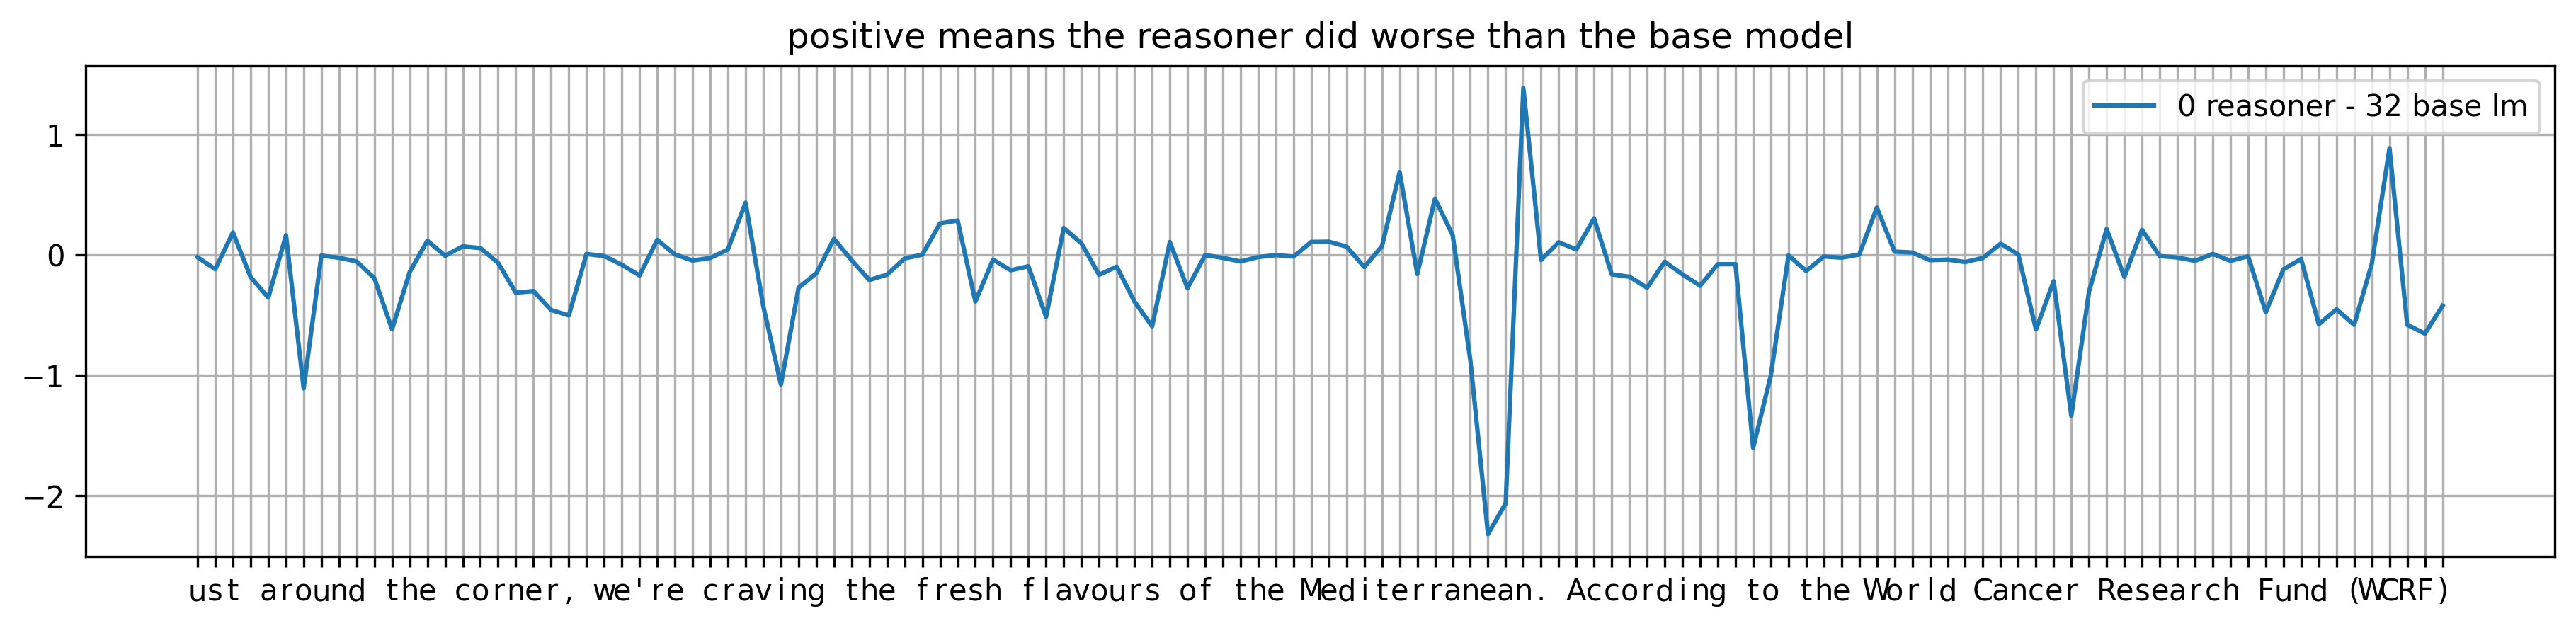

[92, 603, 92, 603, 92, 603, 92, 603, 92, 603]
[('u', ' et', 'y一y一y一y一y一', ' et', 0.9998350143432617, 0.00019735316163860261),
 ('s', 'rst', '½yÎ�ЂyÎ�Ђy', 'rts', 0.9969599843025208, 0.002240327652543783),
 ('t', 'e t', 'y≥y≥y≥y≥y≥', 'et ', 0.937779426574707, 0.046165309846401215),
 (' ', ' ea', 'yعyعyعyعyع', ' oe', 0.997320294380188, 0.002975399838760495),
 ('a', 'tao', '一要�아要아�+아�', 'tas', 0.0057746488600969315, 0.42641481757164),
 ('r', 'n t', 'yyyyyyyyyy', 'nsr', 0.9999366998672485, 8.227743819588795e-05),
 ('o', 'eot', 'ɛɛɛɛɛɛɛɛɛɛ', 'etr', 1.0, -0.0),
 ('u', 'ums', '要要要要要要要要要要', 'umo', 0.9999972581863403, 2.496287379472051e-06),
 ('n', 'nrg', '½½½½½½½½½½', 'ngr', 0.999998927116394, 2.169033678001142e-06),
 ('d', 'dtc', 'y一y一y一y一y一', 'dtg', 0.999997615814209, 3.4767770102916984e-06),
 (' ', ' .,', 'yyyyyyyyyy', ' .s', 0.9621859192848206, 0.025024289265275),
 ('t', 'tah', '一※�※�※�※�※', 'tao', 0.9954860806465149, 0.004049981944262981),
 ('h', 'hor', 'Ç一Ç一γ�│Ç一Ç', 'hor', 0.0557959191501

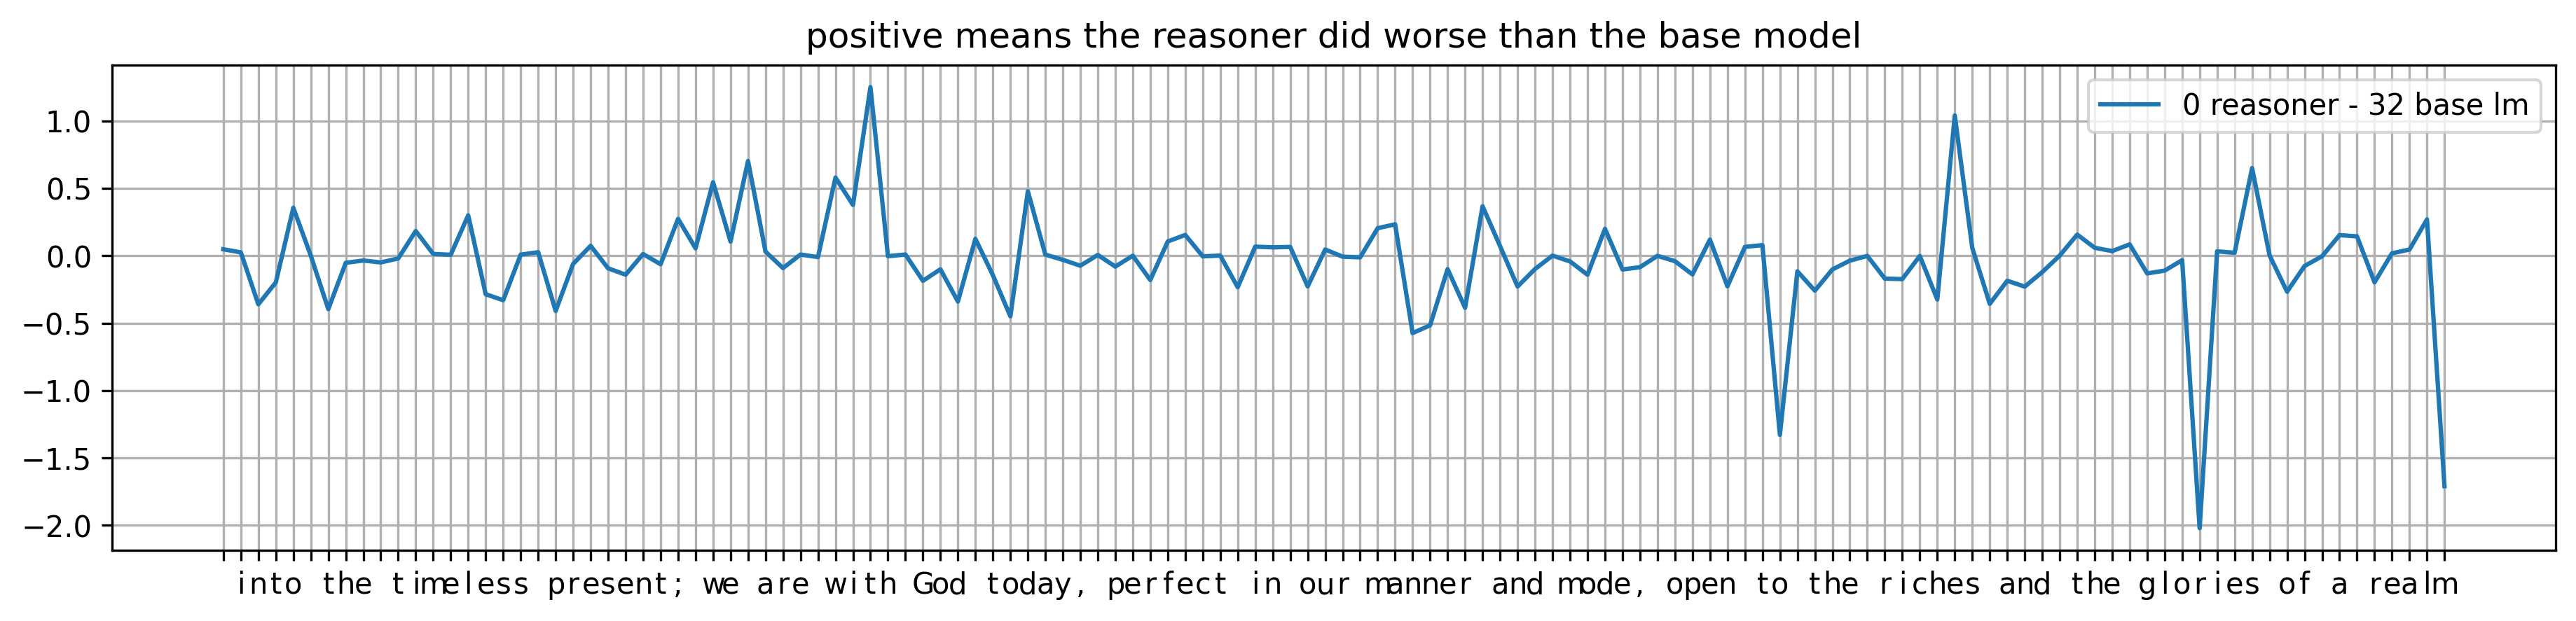

[92, 603, 92, 603, 92, 603, 92, 603, 92, 603]
[(' ', ' et', 'y一y一y一y一y一', ' et', 0.9998350143432617, 0.00019735316163860261),
 ('i', 'tao', '一要Ç一要Ç一要Ç一', 'tao', 0.9527921080589294, 0.0268440842628479),
 ('n', 'nst', 'y½y½y½y½y½', 'snt', 0.9998509883880615, 0.00018266105325892568),
 ('t', ' ts', 'yЂyyyyyyyy', ' tc', 0.0454833023250103, 0.37136808037757874),
 ('o', 'eor', 'ɛːyÎɛyÎɛyÎ', 'eor', 0.1464865654706955, 0.2005726844072342),
 (' ', ' x\n', 'yyyyyyyyyy', ' -r', 0.999998927116394, 1.0728835775353218e-07),
 ('t', 'tas', '一※아※아※아※아※', 'tas', 0.9933086037635803, 0.00504530081525445),
 ('h', 'hre', 'Ç│Ç│ÇοÇ│Ç│', 'hor', 0.023248916491866112, 0.06734232604503632),
 ('e', 'eia', 'yÎ一yÎ一yÎ一y', 'eia', 1.0, -0.0),
 (' ', ' is', 'yyyyyyyyyy', ' iy', 1.0, -0.0),
 ('t', 'scp', '¨î¨î¨î¨î¨î', 'scp', 0.9999998807907104, 1.1920929132713809e-08),
 ('i', 'roe', '¨♡¨î¨♡¨♡¨♡', 'roi', 0.03197326138615608, 0.08149895071983337),
 ('m', 'mtp', 'yÎɛyÎɛyÎɛy', 'mtc', 1.0, -0.0),
 ('e', 'ebi', 'yÎɛyÎɛyÎɛy', 'e

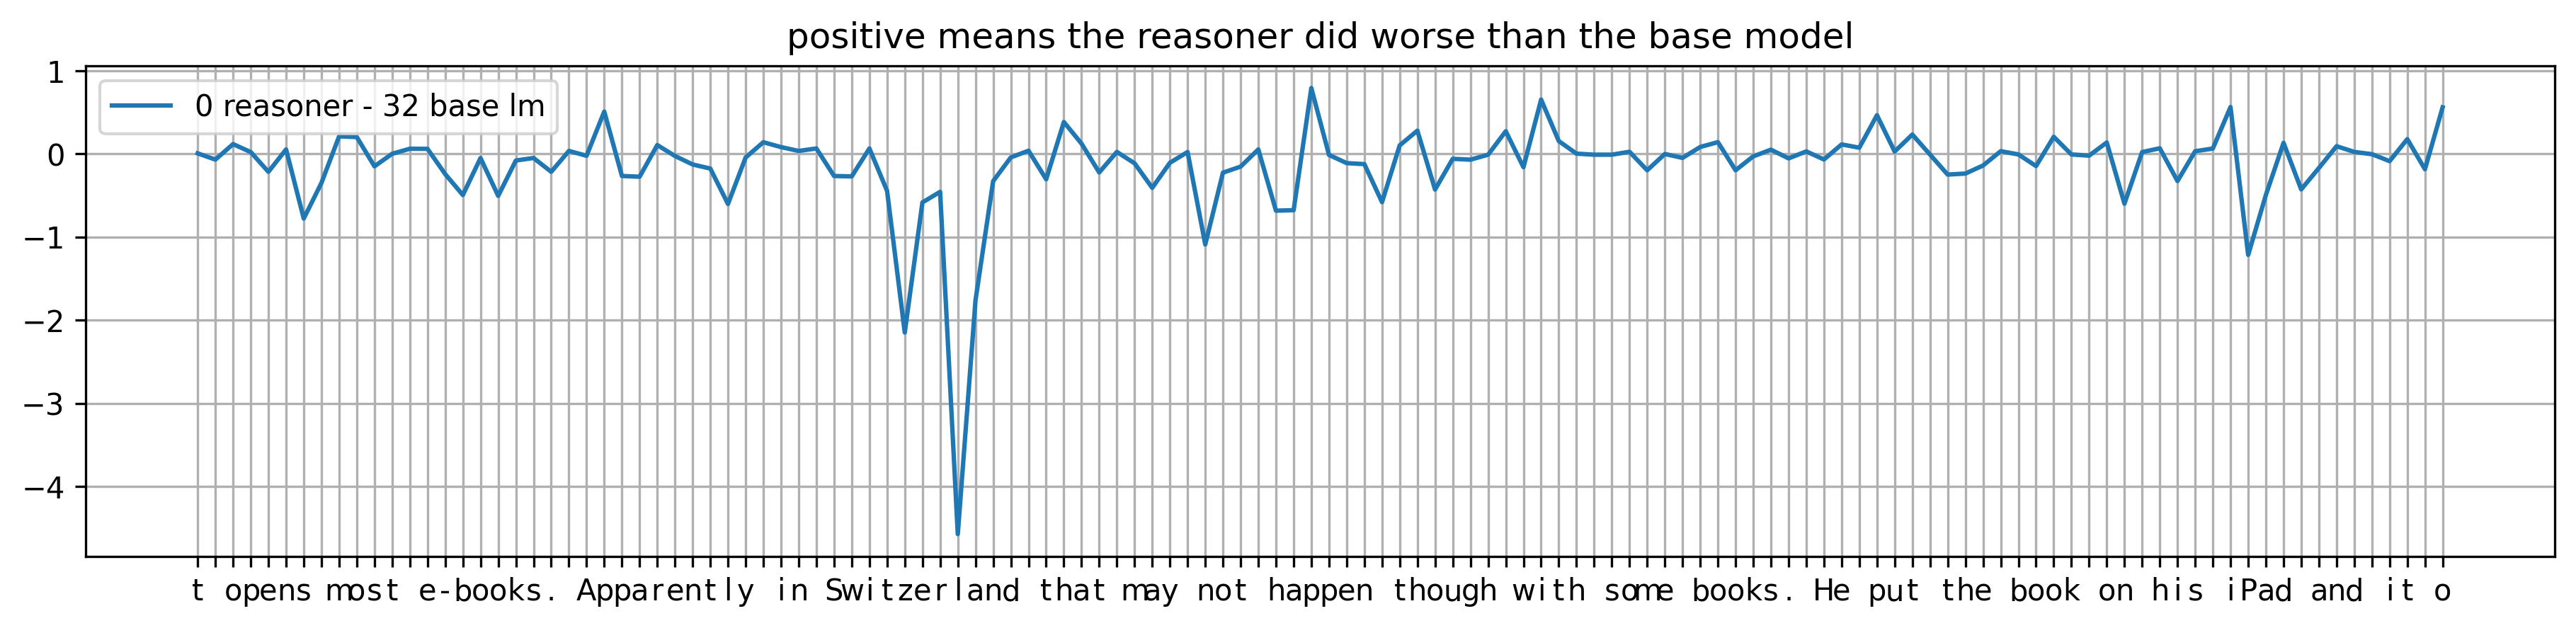

[92, 603, 92, 603, 92, 603, 92, 603, 92, 603]
[('t', ' et', 'y一y一y一y一y一', ' et', 0.9998350143432617, 0.00019735316163860261),
 (' ', 'h e', 'yлyлyлyлyл', 'h i', 0.9941691160202026, 0.0049901241436600685),
 ('o', 'tao', '一要γ아�아�아�아', 'toa', 0.03554756939411163, 0.13634470105171204),
 ('p', 'fnr', '�一фÇ�一фÇ�一', 'fnu', 0.7355626821517944, 0.1326712816953659),
 ('e', 'etp', 'yضyضyضyضyض', 'etp', 1.0, -0.0),
 ('n', 'nrd', 'y�y�y�y�y�', 'nr ', 0.9997305274009705, 0.0002535394160076976),
 ('s', ' ie', 'yعyعyعyعyع', ' ei', 0.8694868683815002, 0.06316547840833664),
 (' ', ' .,', 'yบyบyบyบyบ', ' ea', 0.9545154571533203, 0.029271598905324936),
 ('m', 'tao', '一и���아�и�一', 'ato', 0.0003295579517725855, 0.7134459614753723),
 ('o', 'aoe', 'ииииииииии', 'aoe', 0.7568186521530151, 0.1253993809223175),
 ('s', 'rvn', 'yиyиyиyиyи', 'rnd', 0.9999982118606567, 3.062610176129965e-06),
 ('t', 'tqh', 'yиyиyиyиyи', 'teq', 0.9825971126556396, 0.011672751978039742),
 (' ', ' l.', 'yบyบyบyบyบ', ' l.', 0.96247565746

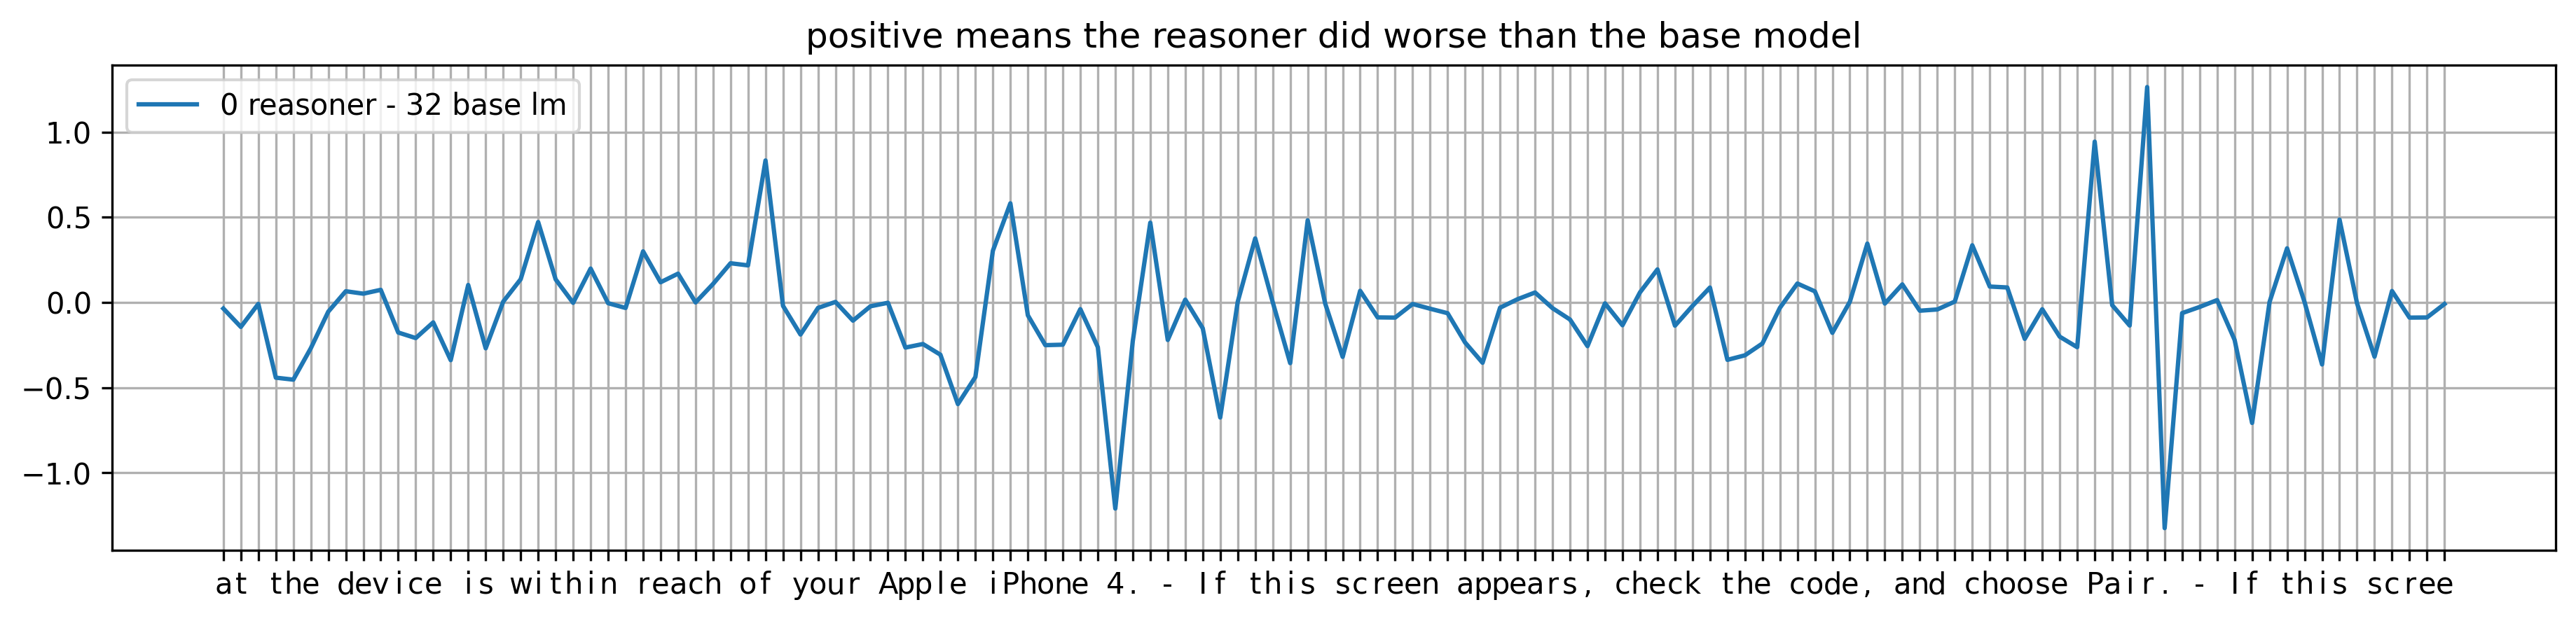

[92, 603, 92, 603, 92, 603, 92, 603, 92, 603]
[('a', ' et', 'y一y一y一y一y一', ' et', 0.9998350143432617, 0.00019735316163860261),
 ('t', 'ntr', 'y아y아y아y아y아', 'ntr', 0.9998849630355835, 0.00014140643179416656),
 (' ', ' ie', 'y£y£y£y£y£', ' ei', 0.9627700448036194, 0.0267434474080801),
 ('t', 'tao', '一要な�ค�ค�ค�', 'tao', 0.4115247130393982, 0.31196099519729614),
 ('h', 'hor', 'γ아│�아│아γ�아', 'hoe', 4.039351551909931e-05, 0.4484739303588867),
 ('e', 'eai', 'yÎ一yÎ一yÎ一y', 'eai', 1.0, -0.0),
 (' ', ' yr', 'yyyyyyyyyy', ' yr', 1.0, -0.0),
 ('d', 'scp', '¨î¨î¨î¨î¨î', 'scp', 0.9999996423721313, 5.63327034797112e-07),
 ('e', 'eai', '¨♡¨♡¨♡¨♡¨♡', 'eia', 0.9995596408843994, 0.00045519453124143183),
 ('v', 'svc', '++++++++++', 'svt', 1.0, -0.0),
 ('i', 'eio', 'ːyÎ学（yÎ学（y', 'eio', 0.9995788335800171, 0.0004383196937851608),
 ('c', 'cls', 'ɛOyÎɛOyÎɛO', 'cle', 0.9999997615814209, 3.073402581321716e-07),
 ('e', 'eit', '▼yÎɛyÎɛyÎɛ', 'etk', 0.9967451095581055, 0.0022006675135344267),
 (' ', ' s.', 'y▼y▼y▼y▼y▼'

In [13]:
def get_nll_from_logits_and_labels(logits, labels):
    shifted_logits = logits[:, :-1].contiguous()
    shifted_labels = labels[:, 1:].contiguous()
    return torch.nn.CrossEntropyLoss(reduction='none')(shifted_logits.view(-1, logits.size(-1)), shifted_labels.view(-1))
def get_nll(model, inputs, print_stuff=False):
    labels = inputs.clone()
    model_return = model(inputs)
    if isinstance(model_return, torch.Tensor):
        logits = model_return
    else:
        assert hasattr(model_return, "logits"), "we assume we are dealing with a huggingface model"
        logits = model_return.logits
    loss_per_token = get_nll_from_logits_and_labels(logits, labels)
    return loss_per_token
def get_model_A_and_ref_loss_print_model_A_reasonings(model_As, ref_model, start_index=0, num_to_print=1, chart_model_A_labels=None, get_losses=False):
    plotted = 0
    points = list()
    points_other = list()
    model_As_loss = [0] * len(model_As)
    base_model_loss = 0
    for i, d in enumerate(val_dl):
        if i < start_index:
            continue
        # d = d.cuda()
        # print(d.shape, d)
        base_model_logits = ref_model(d)
        base_model_loss_per_token = get_nll_from_logits_and_labels(base_model_logits, d)
        # loss_per_token_GRU100BaseLM = get_nll(GRU100BaseLM, d)
        # GRU256BaseLM_logits = GRU256BaseLM(d)
        # loss_per_token_GRU256BaseLM = get_nll_from_logits_and_labels(GRU256BaseLM_logits, d)
        # loss_per_token_GRUReasoner32InterpreterLM = get_nll(GRUReasoner32InterpreterLM, d)
        # loss_per_token_GRUReasoner100InterpreterLM = get_nll(GRUReasoner100InterpreterLM, d)
        # GRUReasoner256InterpreterLM_logits, GRUReasoner256InterpreterLM_reasonings, GRUReasoner256InterpreterLM_reasoning_prob, GRUReasoner256InterpreterLM_reasoning_dist = GRUReasoner256InterpreterLM.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(d)
        model_reasoning_outputs = [model_A.get_logits_and_hidden_states_and_log_prob_hidden_states_dist(d) for model_A in model_As]
        model_As_loss_per_token = [get_nll_from_logits_and_labels(model_reasoning_output[0], d) for model_reasoning_output in model_reasoning_outputs]
        # GRURI32minusGRU32 = loss_per_token_GRUReasoner32InterpreterLM - loss_per_token_GRU32BaseLM
        # GRURI100minusGRU32 = loss_per_token_GRUReasoner100InterpreterLM - loss_per_token_GRU32BaseLM
        model_As_minus_base = [loss_per_token - base_model_loss_per_token for loss_per_token in model_As_loss_per_token]
        # GRURI256minusGRU32 = loss_per_token_GRUReasoner256InterpreterLM - loss_per_token_GRU32BaseLM
        # GRU100minusGRU32 = loss_per_token_GRU100BaseLM - loss_per_token_GRU32BaseLM
        # GRU256minusGRU32 = loss_per_token_GRU256BaseLM - loss_per_token_GRU32BaseLM
        model_As_loss = [prior_loss_per_token + loss_per_token.sum().item() for prior_loss_per_token, loss_per_token in zip(model_As_loss, model_As_loss_per_token)]
        base_model_loss += base_model_loss_per_token.sum().item()
        if get_losses:
            raise NotImplementedError()
            # interesting_mask = GRUReasoner256InterpreterLM_reasonings[0,:-1,0] != start_of_thought_token_id # only take tokens which correspond to thoughts which do not have sot as their first token.
            # points.extend(zip((-GRURI256minusGRU32[interesting_mask]).tolist(), loss_per_token_GRU32BaseLM[interesting_mask].tolist()))
            # points_other.extend(zip((-GRURI256minusGRU32[~interesting_mask]).tolist(), loss_per_token_GRU32BaseLM[~interesting_mask].tolist()))
            # continue # this just for collecting points


        # only plot if there is an extreme example of reasoning being better than just increasing the hidden representation size of the base model.
        # should_plot = False
        # if ((GRU256minusGRU32 - GRURI256minusGRU32 > 3) & (GRU256minusGRU32 < 0)).any():
        #     should_plot = True
        # if not should_plot:
        #     continue
        # if get_losses:
        #     continue
        print(i)
        print(tokenizer.batch_detokenize(d))
        fig = plt.figure(figsize=(15,3), dpi=300)
        xs = range(len(list(d[0, 1:])))
        # plt.plot(xs, GRURI32minusGRU32.tolist(), label="32 reasoner - 32 base lm")
        # plt.plot(xs, GRURI100minusGRU32.tolist(), label="100 reasoner - 32 base lm")
        if chart_model_A_labels is None:
            chart_model_A_labels = list(str(s) for s in range(len(model_As)))
        for chart_model_A_label, model_A_minus_base in zip(chart_model_A_labels, model_As_minus_base):
            plt.plot(xs, model_A_minus_base.tolist(), label=f"{chart_model_A_label} reasoner - 32 base lm")
        # plt.plot(xs, GRU100minusGRU32.tolist(), label="100 base lm - 32 base lm")
        # plt.plot(xs, GRU256minusGRU32.tolist(), label="256 base lm - 32 base lm")
        # plt.plot(xs, (GRU256minusGRU32 - GRURI256minusGRU32).tolist(), label="improvment over base lm increase")
        base_model_dist = base_model_logits.softmax(-1)
        base_model_ent_per_token = torch.where(base_model_dist > 1e-7, -base_model_dist * base_model_dist.log(), torch.zeros_like(base_model_dist)).sum(-1)
        # plt.plot(xs, base_model_ent_per_token[0,:-1].tolist(), label="32 base lm ent per token")
        # plt.plot(xs, (4* GRUReasoner256InterpreterLM_reasoning_prob[0, :-1].sum(-1).exp()).tolist(), label="reasoning probability")
        plt.xticks(xs, labels=[tokenizer.detokenize([t]) for t in d[0,1:].tolist()])
        plt.legend()
        plt.title("positive means the reasoner did worse than the base model")
        # print((loss_per_token_GRUReasoner100InterpreterLM - loss_per_token_GRU32BaseLM).sum())
        plt.grid()
        plt.show()
        def print_reasonings(d, model_A_logits, model_A_reasonings, model_A_reasoning_prob, model_A_reasoning_dist):
            sent_ent = -(torch.where(model_A_reasoning_dist > 1e-7, model_A_reasoning_dist * model_A_reasoning_dist.log(), torch.zeros_like(model_A_reasoning_dist))).sum(-1).mean(-1)
            print(model_A_reasonings[0,0].tolist())
            pprint(list(zip([tokenizer.detokenize([t]) for t in d[0,1:].tolist()], 
                            tokenizer.batch_detokenize(model_A_logits[0].argsort(-1, descending=True)[:,:3]),# top 3 guesses
                            reasoning_tokenizer.batch_detokenize(model_A_reasonings[0]),
                            tokenizer.batch_detokenize(base_model_logits[0].argsort(-1, descending=True)[:,:3]),
                            model_A_reasoning_prob[0].sum(-1).exp().tolist(),
                            sent_ent[0].tolist(),
                            )))
        for model_reasoning_output in model_reasoning_outputs:
            model_A_logits, model_A_reasonings, model_A_reasoning_prob, model_A_reasoning_dist = model_reasoning_output
            print_reasonings(d, model_A_logits, model_A_reasonings, model_A_reasoning_prob, model_A_reasoning_dist)
        
        # print(tokenizer.batch_detokenize(d[:,1:])[0].replace('\n', "/"))
        # print(tokenizer.batch_detokenize(GRU32BaseLM_logits.argmax(-1))[0].replace('\n', "/"))
        # print(tokenizer.batch_detokenize(GRUReasoner256InterpreterLM_logits.argmax(-1))[0].replace('\n', "/"))
        # print(tokenizer.batch_detokenize(GRU256BaseLM_logits.argmax(-1)))

        plotted += 1
        if plotted >= num_to_print: break
    if get_losses:
        return model_As_loss, base_model_loss, points, points_other
# GRUReasoner256InterpreterMix1Ent00016Len50lenpen0001LM.eval()
# GRUReasoner256InterpreterMix1Ent00016Len10LM.eval()
GRUReasoner256InterpreterMix0LM = GRUReasoner256InterpreterMix0LM.eval()
GRUReasoner256InterpreterMix0BaseLM = GRUReasoner256InterpreterMix0BaseLM.eval()
# model_As_loss, base_model_loss, points, points_other = 
get_model_A_and_ref_loss_print_model_A_reasonings(
    [GRUReasoner256InterpreterMix0LM],
    GRUReasoner256InterpreterMix0BaseLM,
    # [GRUReasoner256InterpreterMix1Ent00016Len50lenpen0001LM.cpu(), GRUReasoner256InterpreterMix1Ent00016Len10LM.cpu()],
    # # [GRUReasoner256InterpreterMix1Ent00016Len10LM.cpu()],
    # GRUReasoner256InterpreterMix1BaseLM.cpu(),
    # start_index=10,
    num_to_print=5
)


In [ ]:
model_As_loss, base_model_loss

In [ ]:
print(sum(list(zip(*points))[0]), sum(list(zip(*points_other))[0]))
sum(list(zip(*points))[0]) / len(points), sum(list(zip(*points_other))[0])/ len(points_other)

In [16]:
import seaborn as sns
import random
import matplotlib.colors as mcolors

# Example: Replace this with your actual list of (x, y) tuples

# Convert list to NumPy arrays
sample_points = random.sample(points, min(len(points), 20000))
x_vals, y_vals = zip(*sample_points)

# Create the density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(x=x_vals, y=y_vals, fill=True, cmap="Blues", levels=30, norm=mcolors.LogNorm())

# Labels
plt.xlabel("Improvement in Loss Given Thought")
plt.ylabel("Original Token Prediction Loss")
plt.xlim(-5,5)

# Show plot
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)

In [14]:
len(points)

190336

# Make model have variable length reasoning

In [16]:
# both GRU and Transformer setting. Right now GRU Reasoner Interpreter is the most important setting to add variable length reasoning into.
# rest can hold off.
%load_ext autoreload
%autoreload 2

In [199]:
import torch
from quiet_star_replicate.model.model import LanguageModelLSTM, ReasonerInterpreterGRU
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
# gru_model = torch.nn.GRU(2, 64, 1, batch_first=True)
# packed_inputs = pack_padded_sequence(torch.tensor([[[1,1],[2,2]],[[1,1],[0,0]],[[1,1],[0,0]],[[1,1],[2,2]]]).float(), lengths=[2,1,1,2], batch_first=True, enforce_sorted=False)

# gru_model(packed_inputs)[1].shape

# gru_lm = LanguageModelLSTM(10, 2, 1, model_type='gru', linear_lm_head=False)
# gru_lm.sample(input_ids=torch.zeros((3,1)).long(), max_gen_length=15, greedy=False, return_logits=True, return_terminal_hidden_states=True, variable_len=True, start_and_end_of_thought_token=8, pad_token=9)
ri_model = ReasonerInterpreterGRU(
        vocab_size=10,
        reasoner_interpreter_vocab_size=10,
        base_lm_hidden_dim=2,
        reasoner_hidden_dim=2,
        interpreter_hidden_dim=2,
        use_base_lm=True,
        use_reasoner=True,
        simple_lm_head=True,
        weight_groups=['A',"B","C","D"],
        share_lm_head=None,
        max_reasoning_len=15,
        start_of_thought_token=8,
        variable_len=True,
        pad_token=9
    )
ri_model.cuda()

ri_model(torch.tensor([[0,1,2,3,4],
                       [1,3,3,3,4]]).cuda(), return_dict=True)
# packed_inputs
# pad_packed_sequence(packed_inputs, batch_first=True)

{'output': tensor([[[-0.7181, -0.4539],
          [-0.6805, -0.7295],
          [-0.8570, -0.6281],
          [-0.9666,  0.2488],
          [-1.0087, -0.2610]],
 
         [[-0.6510, -0.4985],
          [-1.1664,  0.4059],
          [-1.1407,  0.3329],
          [-1.2060,  0.2365],
          [-1.2088, -0.3036]]], device='cuda:0', grad_fn=<AddBackward0>),
 'hidden_states': tensor([[[9, 1, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
          [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
          [3, 6, 1, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
          [2, 1, 7, 3, 7, 7, 5, 2, 0, 0, 8, 9, 9, 9, 9],
          [5, 0, 0, 5, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]],
 
         [[2, 0, 1, 3, 9, 7, 9, 8, 9, 9, 9, 9, 9, 9, 9],
          [9, 1, 0, 7, 2, 1, 4, 4, 5, 5, 4, 2, 6, 3, 9],
          [5, 5, 9, 1, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
          [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
          [6, 1, 3, 3, 3, 0, 2, 3, 3, 5, 4, 9, 9, 4, 8]]], device='cuda:0'),
 'log_prob_hidden': tensor([[[-2.

In [ ]:
# check that the distribution entropy isn't screwed up by the uniform stuff produced after the end of thought.
# potentially penalize getting to end of the thought without generating the eot yourself.


10.833333333333334

In [2]:
torch.tensor([[0,1],[1,2]])

tensor([[0, 1],
        [1, 2]])

# Build Tokenizer for fine web

In [1]:
from quiet_star_replicate.data.data import FWDataset, CustomTokenizer
%load_ext autoreload
%autoreload 2

In [2]:
dataset = FWDataset.load("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/", seq_len=128)

In [3]:
data_str = ''.join(dataset.data)

In [6]:
from collections import Counter
counter = Counter(data_str)

In [16]:
len({k for k, v in counter.items() if v > 100})
# what is the difference in speed/performance? 
# I don't care too much about the tokens which are unk. 
# Modeling them doesn't matter too much for me does it?

722

In [4]:
tokenizer = CustomTokenizer(data_str, min_freq=100)

In [5]:
len(tokenizer.vocab)

724

In [6]:
tokenizer.save("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/", "fwv2")

In [7]:
tokenizer_2 = CustomTokenizer.load("/coc/flash9/jbjorner3/quiet-star-test-eval-models/datasets/", "fwv2")

In [10]:
tokenizer_2.vocab

['<bos>',
 '<unk>',
 '\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '}',
 '~',
 '\xa0',
 '¡',
 '¢',
 '£',
 '¤',
 '¥',
 '¦',
 '§',
 '¨',
 '©',
 '«',
 '¬',
 '®',
 '¯',
 '°',
 '±',
 '²',
 '³',
 '´',
 'µ',
 '¶',
 '·',
 '¸',
 '¹',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Â',
 'Ã',
 'Ä',
 'Å',
 'Æ',
 'Ç',
 'È',
 'É',
 'Ê',
 'Ì',
 'Í',
 'Î',
 'Ð',
 'Ñ',
 'Ó',
 'Ô',
 'Ö',
 '×',
 'Ø',
 'Ú',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í